In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal
from statsmodels.stats.multitest import multipletests

from TISSUE.tissue.main import *

## Simulation studies

Simulate imputation model as randomly adding Gaussian noise to the true measurement. The Gaussian is different between the two conditions for half of the genes with mu offset and the other half is fine. (Measurement also adds zero-centered Gaussian noise from the ground truth values). Define FDR with respect to the ground truth values.

In [6]:
def simulate_data (mu, p=1000, sigma_measurement=1, sigma_imputation=1, n_test=100):
    '''
    Creates data for simulation of imputation bias between conditions
    '''
    # create ground truth
    truth = np.zeros((100,p)) # ground truth is that there is no difference between anything
    
    # condition labels
    labels = np.zeros(100)
    labels[50:] = 1
    
    # create spatial coords
    spatial_x = []
    spatial_y = []
    
    for i in range(10):
        for j in range(10):
            spatial_x.append(i)
            spatial_y.append(j)
            
    spatial = np.vstack((spatial_x,spatial_y)).T
    
    # create measurement (Gaussian noise)
    measured = truth + np.random.normal(0,sigma_measurement,truth.shape)
    
    # create imputed
    imputed = np.zeros(measured.shape)
    
    # impute one half consistently with zero-centered Gaussian noise
    imputed[:,:round(p/2)] = measured[:,:round(p/2)] + np.random.normal(0,sigma_imputation,(imputed.shape[0],round(p/2)))
    
    # impute other half with bias of mu offset for one group
    imputed[:50,round(p/2):] = measured[:50,round(p/2):] + np.random.normal(0,sigma_imputation,
                                                                        (50,imputed.shape[1]-round(p/2)))
    imputed[50:,round(p/2):] = measured[50:,round(p/2):] + np.random.normal(mu,sigma_imputation,
                                                                        (50,imputed.shape[1]-round(p/2)))
    
    # create adata
    adata = ad.AnnData(measured)
    adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
    adata.obsm["spatial"] = spatial
    adata.obs["condition"] = labels.astype(int).astype(str)
    
    # get calib genes
    calib_genes=adata.var_names[:-n_test]
    
    return (adata, calib_genes)

In [7]:
p_cutoff = 0.05
mu_offsets = np.linspace(0,2,30)

err_dict = {}
err_dict["measured"] = {}
err_dict["measured"]["mean"] = []
err_dict["measured"]["range"] = []
err_dict["imputed"] = {}
err_dict["imputed"]["mean"] = []
err_dict["imputed"]["range"] = []
err_dict["mi"] = {}
err_dict["mi"]["mean"] = []
err_dict["mi"]["range"] = []


for mu in mu_offsets:
    
    err_measured = []
    err_imputed = []
    err_mi = []
    
    for i in range(20):
        
        adata, calib_genes = simulate_data(mu)
        
        # build spatial graph
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
        calc_adjacency_weights(adata, method="cosine")

        # conformalize
        conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                         grouping_method="kmeans_gene_cell", k=2, k2=2, n_pc=15)
        
        # mi testing
        multiple_imputation_testing (adata, "sim_predicted_expression", calib_genes, "condition", n_imputations=100,
                             group1="0", group2="1", symmetric=False)
        #break
        
        ##### Get p-values and error rates
        g1_bool = (adata.obs["condition"] == "0") # g1
        g2_bool = (adata.obs["condition"] != "0") # all other
        
        bonferroni_factor = 100 # n_test = 100
        
        # measured values
        tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
        pp = pp[-100:]
        #fdr = np.nanmean(pp < p_cutoff/bonferroni_factor)
        rejected = multipletests(pp, alpha=p_cutoff, method='fdr_bh')[0]
        err = np.nanmean(rejected)
        err_measured.append(err)

        # point estimate (from just imputed values)
        tt, pp = two_sample_ttest(adata.obsm["sim_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
        pp = pp[-100:]
        #fdr = np.nanmean(pp < p_cutoff/bonferroni_factor)
        rejected = multipletests(pp, alpha=p_cutoff, method='fdr_bh')[0]
        err = np.nanmean(rejected)
        err_imputed.append(err)
        
        # mi values
        pp = adata.uns['sim_0_1_pvalue'][adata.var_names].values
        pp = pp[0][-100:]
        #fdr = np.nanmean(pp < p_cutoff/bonferroni_factor)
        rejected = multipletests(pp, alpha=p_cutoff, method='fdr_bh')[0]
        err = np.nanmean(rejected)
        err_mi.append(err)
    
    #break
    
    # append results
    err_dict["measured"]["mean"].append(np.nanmean(err_measured))
    err_dict["imputed"]["mean"].append(np.nanmean(err_imputed))
    err_dict["mi"]["mean"].append(np.nanmean(err_mi))
    
    err_dict["measured"]["range"].append((np.nanmin(err_measured),(np.nanmax(err_measured))))
    err_dict["imputed"]["range"].append((np.nanmin(err_imputed),(np.nanmax(err_imputed))))
    err_dict["mi"]["range"].append((np.nanmin(err_mi),(np.nanmax(err_mi))))

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_248/68117129.py:39: FutureWarning: X.dty

In [8]:
# pickle dict
# with open(f"results/hypothesis_testing/simulated_mu_0_3_30_default_params_20rep.pkl", "wb") as f:
#     pickle.dump(err_dict, f)
# with open(f"results/hypothesis_testing/simulated_mu_0_2_30_default_params_20rep_new.pkl", "wb") as f:
#     pickle.dump(err_dict, f)

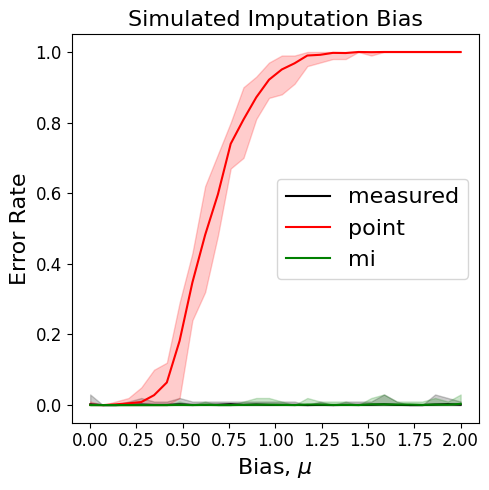

In [9]:
filename = "simulated_mu_0_2_30_default_params_20rep_new"
mu_offsets = np.linspace(0,2,30)

############### expectation is 0.05/100 = 0.0005

with open(f"results/hypothesis_testing/{filename}.pkl", "rb") as f:
    err_dict = pickle.load(f)

plt.figure(figsize=(5,5))

plt.plot(mu_offsets, err_dict["measured"]["mean"], label="measured", color="k")
plt.plot(mu_offsets, err_dict["imputed"]["mean"], label="point", color="r")
plt.plot(mu_offsets, err_dict["mi"]["mean"], label="mi", color="g")

plt.fill_between(mu_offsets, [x[0] for x in err_dict["measured"]["range"]],
                 [x[1] for x in err_dict["measured"]["range"]], color="k", alpha=0.2)
plt.fill_between(mu_offsets, [x[0] for x in err_dict["imputed"]["range"]],
                 [x[1] for x in err_dict["imputed"]["range"]], color="r", alpha=0.2)
plt.fill_between(mu_offsets, [x[0] for x in err_dict["mi"]["range"]],
                 [x[1] for x in err_dict["mi"]["range"]], color="g", alpha=0.2)

plt.title("Simulated Imputation Bias", fontsize=16)
plt.xlabel(r"Bias, $\mu$", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
#plt.savefig(f"plots/scpi_dgea/{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"plots/scpi_dgea/{filename}.pdf")
plt.show()

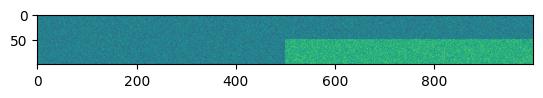

In [12]:
plt.imshow(adata.obsm['sim_predicted_expression'])

## Generate dictionary from results from datasets

In [10]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
conditions = ["celltype_lowres", "region", "Region"]


##################
combined_stat_result_dict = {}

for i in range(len(dataset_names)):

    condition=conditions[i]
    dataset_name=dataset_names[i]

    adata = sc.read_h5ad(f'scg_results/scpi/2023Feb20_k4k1_SDbasedCCplus1/{dataset_name}_knn_spage_tangram_MI_TTEST.h5ad')

    combined_stat_result_dict[dataset_name] = {}

    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}

        for g1 in np.unique(adata.obs[condition]):

            key = str(g1)+"_all"
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other

            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values

            # add from var 
            var_key = method+"_"+key
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.var[var_key+"_tstat"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.var[var_key+"_varw"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.var[var_key+"_varb"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.var[var_key+"_poolmean"].values

            # true values
            tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["true_tstat"] = tt

            # point estimate (from just imputed values)
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "wb") as f:
    pickle.dump(combined_stat_result_dict, f)

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:2170: RuntimeWarning: invalid value encountered in true_divide
  tt = mean_diff/pooled_sd


## P-value and t-statistic correlations

/tmp/ipykernel_90/628858006.py:35: RuntimeWarning: divide by zero encountered in log10
  agg_x = -np.log10(agg_x)
/tmp/ipykernel_90/628858006.py:36: RuntimeWarning: divide by zero encountered in log10
  agg_y = -np.log10(agg_y)


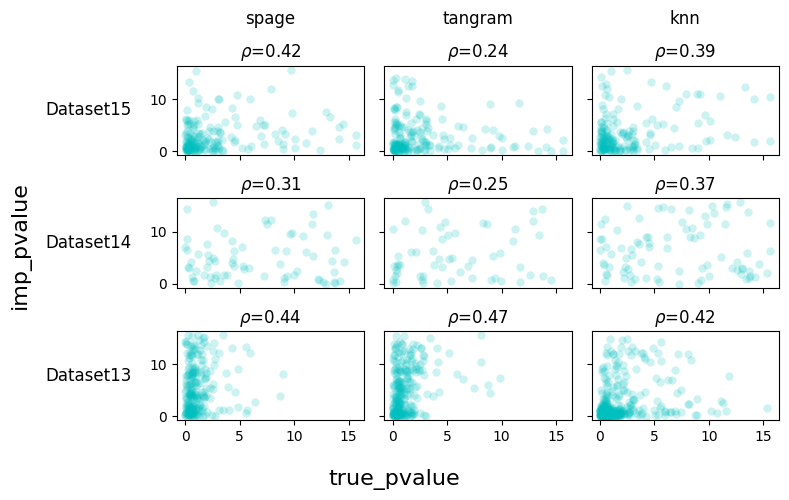

In [11]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset15", "Dataset14", "Dataset13"]
xlab = "true_pvalue"
ylab = "imp_pvalue"

transform = "neglog10"

########################################

with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(8,5), sharex=True, sharey=True)

for i, dataset in enumerate(combined_stat_result_dict.keys()):
    
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y = np.concatenate((agg_y, combined_stat_result_dict[dataset][method][g1][ylab]))
        
        # transform if needed
        if transform == "neglog10":
            agg_x = -np.log10(agg_x)
            agg_y = -np.log10(agg_y)
        
        # compute correlation (rank/spearman)
        r,p = spearmanr(agg_x[~(np.isnan(agg_x))&~(np.isnan(agg_y))], agg_y[~(np.isnan(agg_x))&~(np.isnan(agg_y))])
        
        # make plot
        axs[i, j].scatter(agg_x, agg_y, c='c', alpha=0.2, linewidths=0)
        axs[i, j].set_title(r"$\rho$="+str(round(r,2)), fontsize=12)

# axis labels
fig.supxlabel(xlab, fontsize=16)
fig.supylabel(ylab, fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 30
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/"+xlab+"_"+ylab+".png", dpi=500, bbox_inches='tight')
plt.show()

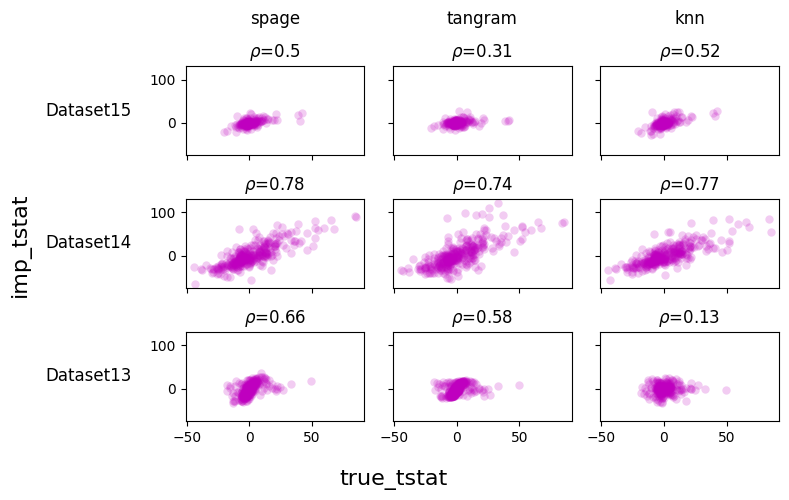

In [12]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset15", "Dataset14", "Dataset13"]
xlab = "true_tstat"
ylab = "imp_tstat"

transform = None

########################################

with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(8,5), sharex=True, sharey=True)

for i, dataset in enumerate(combined_stat_result_dict.keys()):
    
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y = np.concatenate((agg_y, combined_stat_result_dict[dataset][method][g1][ylab]))
        
        # transform if needed
        if transform == "neglog10":
            agg_x = -np.log10(agg_x)
            agg_y = -np.log10(agg_y)
        
        # compute correlation (rank/spearman)
        r,p = spearmanr(agg_x[~(np.isnan(agg_x))&~(np.isnan(agg_y))], agg_y[~(np.isnan(agg_x))&~(np.isnan(agg_y))])
        
        # make plot
        axs[i, j].scatter(agg_x, agg_y, c='m', alpha=0.2, linewidths=0)
        axs[i, j].set_title(r"$\rho$="+str(round(r,2)), fontsize=12)

# axis labels
fig.supxlabel(xlab, fontsize=16)
fig.supylabel(ylab, fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 30
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/"+xlab+"_"+ylab+".png", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_90/2776118672.py:35: RuntimeWarning: divide by zero encountered in log10
  agg_x = -np.log10(agg_x)
/tmp/ipykernel_90/2776118672.py:36: RuntimeWarning: divide by zero encountered in log10
  agg_y = -np.log10(agg_y)


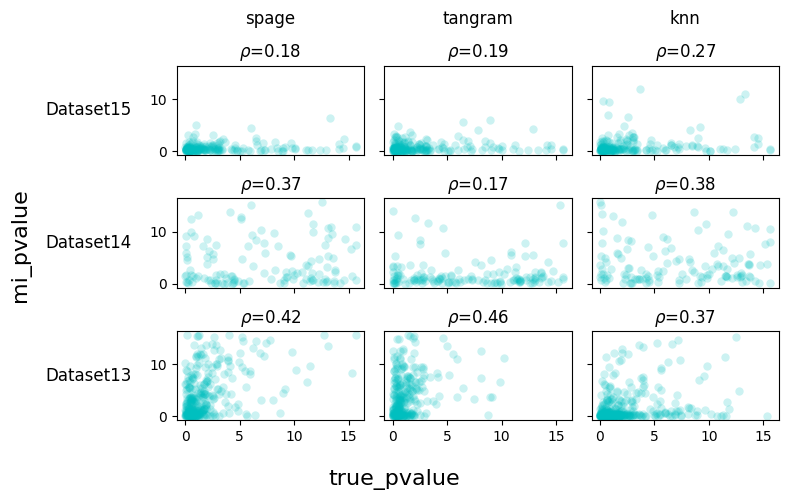

In [13]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset15", "Dataset14", "Dataset13"]
xlab = "true_pvalue"
ylab = "mi_pvalue"

transform = "neglog10"

########################################

with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(8,5), sharex=True, sharey=True)

for i, dataset in enumerate(combined_stat_result_dict.keys()):
    
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y = np.concatenate((agg_y, combined_stat_result_dict[dataset][method][g1][ylab]))
        
        # transform if needed
        if transform == "neglog10":
            agg_x = -np.log10(agg_x)
            agg_y = -np.log10(agg_y)
        
        # compute correlation (rank/spearman)
        r,p = spearmanr(agg_x[~(np.isnan(agg_x))&~(np.isnan(agg_y))], agg_y[~(np.isnan(agg_x))&~(np.isnan(agg_y))])
        
        # make plot
        axs[i, j].scatter(agg_x, agg_y, c='c', alpha=0.2, linewidths=0)
        axs[i, j].set_title(r"$\rho$="+str(round(r,2)), fontsize=12)

# axis labels
fig.supxlabel(xlab, fontsize=16)
fig.supylabel(ylab, fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 30
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/"+xlab+"_"+ylab+".png", dpi=500, bbox_inches='tight')
plt.show()

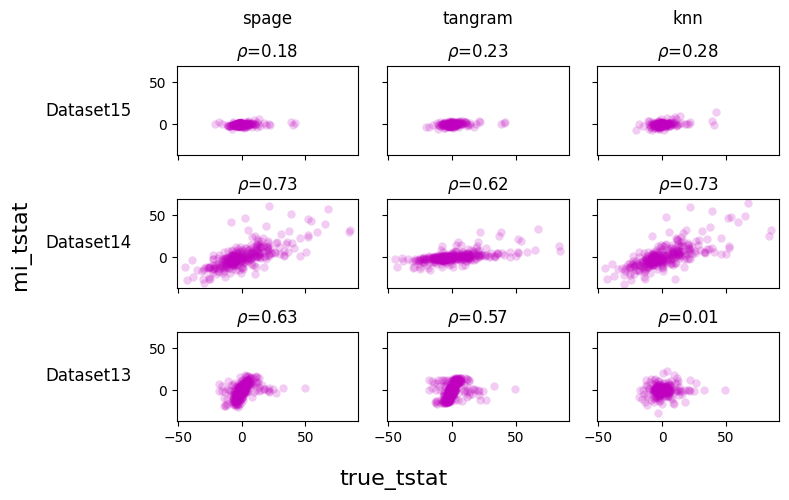

In [14]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset15", "Dataset14", "Dataset13"]
xlab = "true_tstat"
ylab = "mi_tstat"

transform = None

########################################

with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(8,5), sharex=True, sharey=True)

for i, dataset in enumerate(combined_stat_result_dict.keys()):
    
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y = np.concatenate((agg_y, combined_stat_result_dict[dataset][method][g1][ylab]))
        
        # transform if needed
        if transform == "neglog10":
            agg_x = -np.log10(agg_x)
            agg_y = -np.log10(agg_y)
        
        # compute correlation (rank/spearman)
        r,p = spearmanr(agg_x[~(np.isnan(agg_x))&~(np.isnan(agg_y))], agg_y[~(np.isnan(agg_x))&~(np.isnan(agg_y))])
        
        # make plot
        axs[i, j].scatter(agg_x, agg_y, c='m', alpha=0.2, linewidths=0)
        axs[i, j].set_title(r"$\rho$="+str(round(r,2)), fontsize=12)

# axis labels
fig.supxlabel(xlab, fontsize=16)
fig.supylabel(ylab, fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 30
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/"+xlab+"_"+ylab+".png", dpi=500, bbox_inches='tight')
plt.show()

## Confusion Matrix Stats

In [12]:
# CONFUSION MATRIX STATS (Hard Cutoff)

p_cutoff_uncorrected = 0.05 # will do bonferroni cutoff
xlab = "true_pvalue"
ylab = "imp_pvalue"

###############################################
total_confusion_matrix = np.zeros((2,2))

for i, dataset in enumerate(combined_stat_result_dict.keys()):
    
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y = np.concatenate((agg_y, combined_stat_result_dict[dataset][method][g1][ylab]))
        
        # get positive hits
        true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
        imp_labels = agg_y < p_cutoff_uncorrected/len(agg_y)
        
        # make confusion matrix
        confusion_matrix = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                      np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                      [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                       np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
        
        # add to total
        total_confusion_matrix += confusion_matrix

        # print results
        confusion_matrix_df = pd.DataFrame(confusion_matrix,
                                         columns=[ylab+" (+)", ylab+" (-)"],
                                         index = [xlab+" (+)", xlab+" (-)"])
        print(f"{dataset} -- {method}")
        print(confusion_matrix_df)
        print("\n")
        print(f"FDR = {confusion_matrix[1,0]/(confusion_matrix[1,0]+confusion_matrix[0,0])}")
        print(f"FOR = {confusion_matrix[0,1]/(confusion_matrix[0,1]+confusion_matrix[1,1])}")
        print("\n\n\n")

    
# total
print("TOTAL")
confusion_matrix_df = pd.DataFrame(total_confusion_matrix,
                                     columns=["Imputed Positive", "Imputed Negative"],
                                     index = ["Measured Positive", "Measured Negative"])
print(confusion_matrix_df)
print("\n")
print(f"FDR = {total_confusion_matrix[1,0]/(total_confusion_matrix[1,0]+total_confusion_matrix[0,0])}")
print(f"FOR = {total_confusion_matrix[0,1]/(total_confusion_matrix[0,1]+total_confusion_matrix[1,1])}")
print(f"F1 = {2*total_confusion_matrix[0,0]/(2*total_confusion_matrix[0,0]+total_confusion_matrix[0,1]+total_confusion_matrix[1,0])}")
print("\n\n")

Dataset15 -- spage
                 imp_pvalue (+)  imp_pvalue (-)
true_pvalue (+)              52              22
true_pvalue (-)              43             107


FDR = 0.45263157894736844
FOR = 0.17054263565891473




Dataset15 -- tangram
                 imp_pvalue (+)  imp_pvalue (-)
true_pvalue (+)              38              36
true_pvalue (-)              54              96


FDR = 0.5869565217391305
FOR = 0.2727272727272727




Dataset15 -- knn
                 imp_pvalue (+)  imp_pvalue (-)
true_pvalue (+)              54              20
true_pvalue (-)              51              99


FDR = 0.4857142857142857
FOR = 0.16806722689075632




Dataset14 -- spage
                 imp_pvalue (+)  imp_pvalue (-)
true_pvalue (+)             243              36
true_pvalue (-)              42              15


FDR = 0.14736842105263157
FOR = 0.7058823529411765




Dataset14 -- tangram
                 imp_pvalue (+)  imp_pvalue (-)
true_pvalue (+)             252              27
tru

In [13]:
# CONFUSION MATRIX STATS (Hard Cutoff)

p_cutoff_uncorrected = 0.05 # will do bonferroni cutoff
xlab = "true_pvalue"
ylab = "mi_pvalue"

###############################################
total_confusion_matrix = np.zeros((2,2))

for i, dataset in enumerate(combined_stat_result_dict.keys()):
    
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y = np.concatenate((agg_y, combined_stat_result_dict[dataset][method][g1][ylab]))
        
        # get positive hits
        true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
        imp_labels = agg_y < p_cutoff_uncorrected/len(agg_y)
        
        # make confusion matrix
        confusion_matrix = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                      np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                      [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                       np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
        
        # add to total
        total_confusion_matrix += confusion_matrix

        # print results
        confusion_matrix_df = pd.DataFrame(confusion_matrix,
                                         columns=[ylab+" (+)", ylab+" (-)"],
                                         index = [xlab+" (+)", xlab+" (-)"])
        print(f"{dataset} -- {method}")
        print(confusion_matrix_df)
        print("\n")
        print(f"FDR = {confusion_matrix[1,0]/(confusion_matrix[1,0]+confusion_matrix[0,0])}")
        print(f"FOR = {confusion_matrix[0,1]/(confusion_matrix[0,1]+confusion_matrix[1,1])}")
        print("\n\n\n")

    
# total
print("TOTAL")
confusion_matrix_df = pd.DataFrame(total_confusion_matrix,
                                     columns=["Imputed Positive", "Imputed Negative"],
                                     index = ["Measured Positive", "Measured Negative"])
print(confusion_matrix_df)
print("\n")
print(f"FDR = {total_confusion_matrix[1,0]/(total_confusion_matrix[1,0]+total_confusion_matrix[0,0])}")
print(f"FOR = {total_confusion_matrix[0,1]/(total_confusion_matrix[0,1]+total_confusion_matrix[1,1])}")
print(f"F1 = {2*total_confusion_matrix[0,0]/(2*total_confusion_matrix[0,0]+total_confusion_matrix[0,1]+total_confusion_matrix[1,0])}")
print("\n\n")

Dataset15 -- spage
                 mi_pvalue (+)  mi_pvalue (-)
true_pvalue (+)              4             70
true_pvalue (-)              1            149


FDR = 0.2
FOR = 0.319634703196347




Dataset15 -- tangram
                 mi_pvalue (+)  mi_pvalue (-)
true_pvalue (+)              6             68
true_pvalue (-)              2            148


FDR = 0.25
FOR = 0.3148148148148148




Dataset15 -- knn
                 mi_pvalue (+)  mi_pvalue (-)
true_pvalue (+)             14             60
true_pvalue (-)              5            145


FDR = 0.2631578947368421
FOR = 0.2926829268292683




Dataset14 -- spage
                 mi_pvalue (+)  mi_pvalue (-)
true_pvalue (+)            190             89
true_pvalue (-)             30             27


FDR = 0.13636363636363635
FOR = 0.7672413793103449




Dataset14 -- tangram
                 mi_pvalue (+)  mi_pvalue (-)
true_pvalue (+)             79            200
true_pvalue (-)             10             47


FDR = 0.11235955

## Make plots of FDR as function of the p-value cutoff

/tmp/ipykernel_43/731133754.py:63: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_43/731133754.py:64: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
/tmp/ipykernel_43/731133754.py:67: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
/tmp/ipykernel_43/731133754.py:67: RuntimeWarning: invalid value encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
/tmp/ipykernel_43/731133754.py:68: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='g', label="MI")
/tmp/ipykernel_43/731133754.py:68: RuntimeWarning: invalid value encountered in log10
  axs[i,

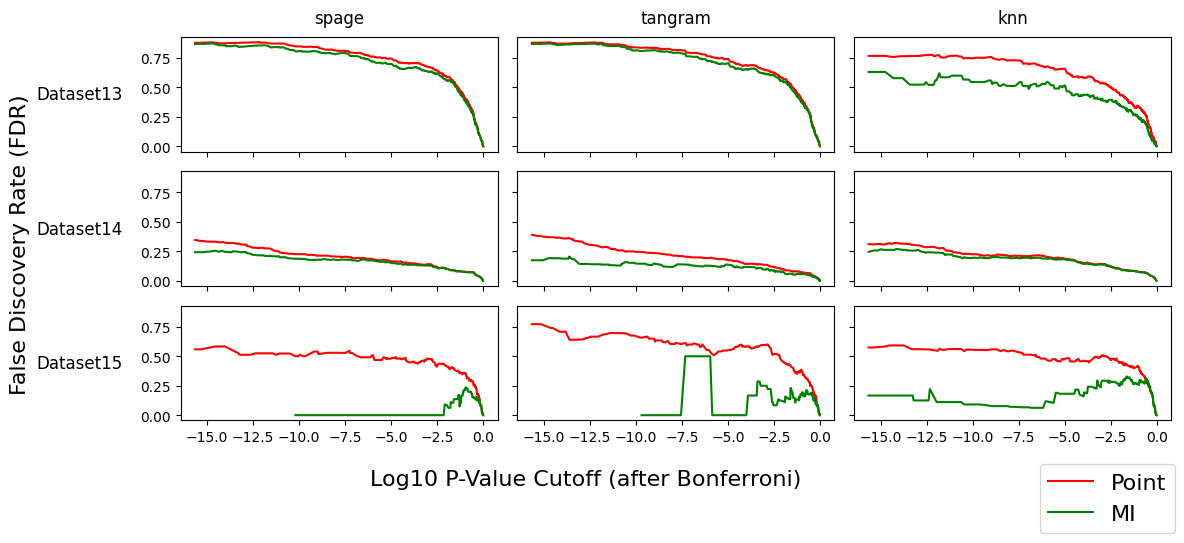

In [3]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(12,5), sharex=True, sharey=True)
    
    
    
for i, dataset in enumerate(combined_stat_result_dict.keys()):
            
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in p_cutoff_uncorrected_arr:
            
            # get positive hits
            #true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
            #imp_labels = agg_y1 < p_cutoff_uncorrected/len(agg_y1)
            #mi_labels = agg_y2 < p_cutoff_uncorrected/len(agg_y2)
            true_labels = multipletests(agg_x, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            imp_labels = multipletests(agg_y1, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            mi_labels = multipletests(agg_y2, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])

            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
        
        
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='g', label="MI")

# legend
fig.legend(["Point", "MI"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Log10 P-Value Cutoff (after Bonferroni)", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/paneled_pvalue_dosage_fdr_curves.pdf", bbox_inches='tight')
plt.show()

## FDR as function of number positives

/tmp/ipykernel_248/1767830529.py:69: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_248/1767830529.py:70: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


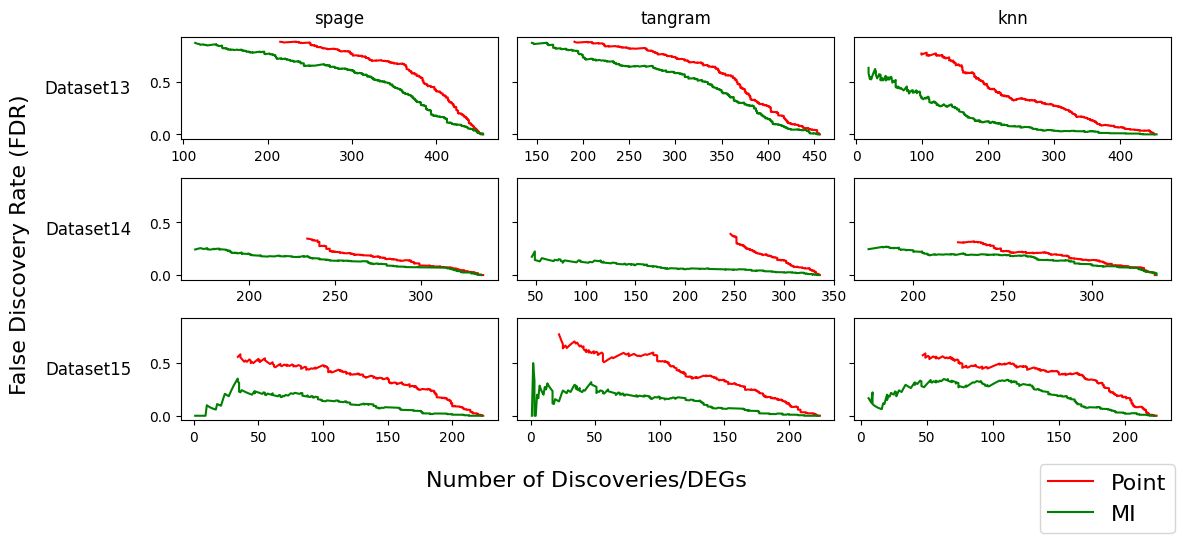

In [15]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
#p_cutoff_uncorrected_arr = np.concatenate(([-1], 10**np.concatenate((np.linspace(-50, -10, 10000),np.linspace(-10, 3, 10000))))) # will do bonferroni cutoff
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(12,5), sharex=False, sharey=True)
    
    
    
for i, dataset in enumerate(combined_stat_result_dict.keys()):
            
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        num_pos_1 = []
        num_pos_2 = []
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            #true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
            #imp_labels = agg_y1 < p_cutoff_uncorrected/len(agg_y1)
            #mi_labels = agg_y2 < p_cutoff_uncorrected/len(agg_y2)
            #true_labels = multipletests(agg_x, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            #imp_labels = multipletests(agg_y1, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            #mi_labels = multipletests(agg_y2, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])

            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        
        axs[i, j].plot(num_pos_1, fdr_list_1, color='r', label="Point")
        axs[i, j].plot(num_pos_2, fdr_list_2, color='g', label="MI")

# legend
fig.legend(["Point", "MI"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/paneled_pvalue_numpositives_fdr_curves.pdf", bbox_inches='tight')
plt.show()

In [13]:
p_cutoff_uncorrected_arr<1e-324

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### Results for other $k_g$ and $k_c$ choices

In [7]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
conditions = ["celltype_lowres", "region", "Region"]


##################
combined_stat_result_dict = {}

for i in range(len(dataset_names)):

    condition=conditions[i]
    dataset_name=dataset_names[i]

    adata = sc.read_h5ad(f'scg_results/scpi/2023Mar4_k4k2_SDbasedCCplus1/{dataset_name}_knn_spage_tangram_MI_TTEST.h5ad')

    combined_stat_result_dict[dataset_name] = {}

    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}

        for g1 in np.unique(adata.obs[condition]):

            key = str(g1)+"_all"
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other

            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values

            # add from var 
            var_key = method+"_"+key
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.var[var_key+"_tstat"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.var[var_key+"_varw"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.var[var_key+"_varb"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.var[var_key+"_poolmean"].values

            # true values
            tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["true_tstat"] = tt

            # point estimate (from just imputed values)
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_k4k2.pkl", "wb") as f:
    pickle.dump(combined_stat_result_dict, f)

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:2170: RuntimeWarning: invalid value encountered in true_divide
  tt = mean_diff/pooled_sd


/tmp/ipykernel_43/1625004461.py:63: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_43/1625004461.py:64: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
/tmp/ipykernel_43/1625004461.py:67: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
/tmp/ipykernel_43/1625004461.py:67: RuntimeWarning: invalid value encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
/tmp/ipykernel_43/1625004461.py:68: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='g', label="MI")
/tmp/ipykernel_43/1625004461.py:68: RuntimeWarning: invalid value encountered in log10
  

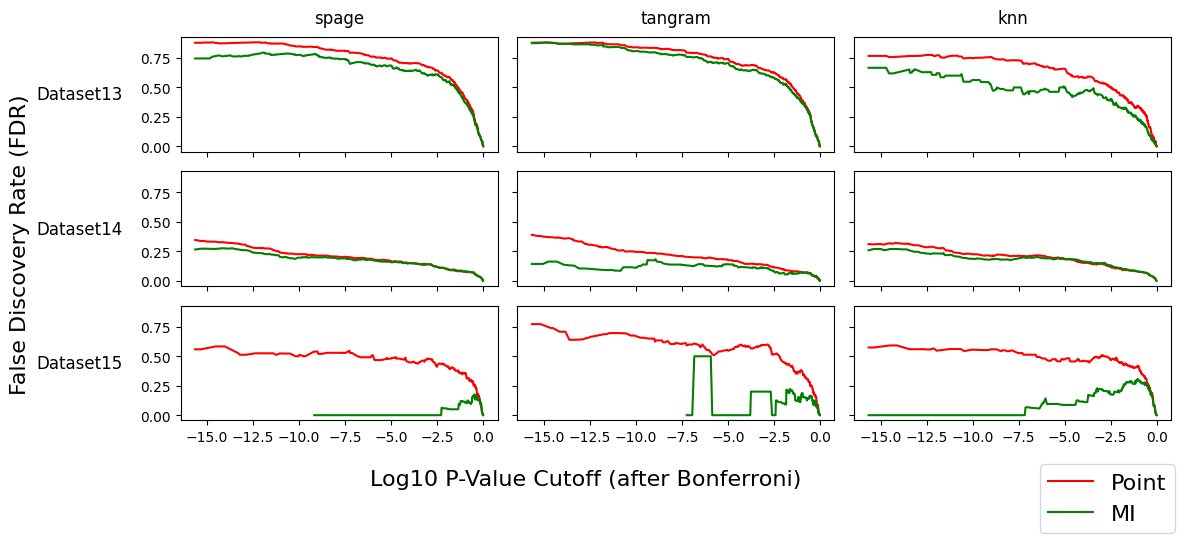

In [4]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_k4k2.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(12,5), sharex=True, sharey=True)
    
    
    
for i, dataset in enumerate(combined_stat_result_dict.keys()):
            
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in p_cutoff_uncorrected_arr:
            
            # get positive hits
            #true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
            #imp_labels = agg_y1 < p_cutoff_uncorrected/len(agg_y1)
            #mi_labels = agg_y2 < p_cutoff_uncorrected/len(agg_y2)
            true_labels = multipletests(agg_x, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            imp_labels = multipletests(agg_y1, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            mi_labels = multipletests(agg_y2, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])

            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
        
        
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='g', label="MI")

# legend
fig.legend(["Point", "MI"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Log10 P-Value Cutoff (after Bonferroni)", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/paneled_pvalue_dosage_fdr_curves_k4k2.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_90/880113461.py:69: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_90/880113461.py:70: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


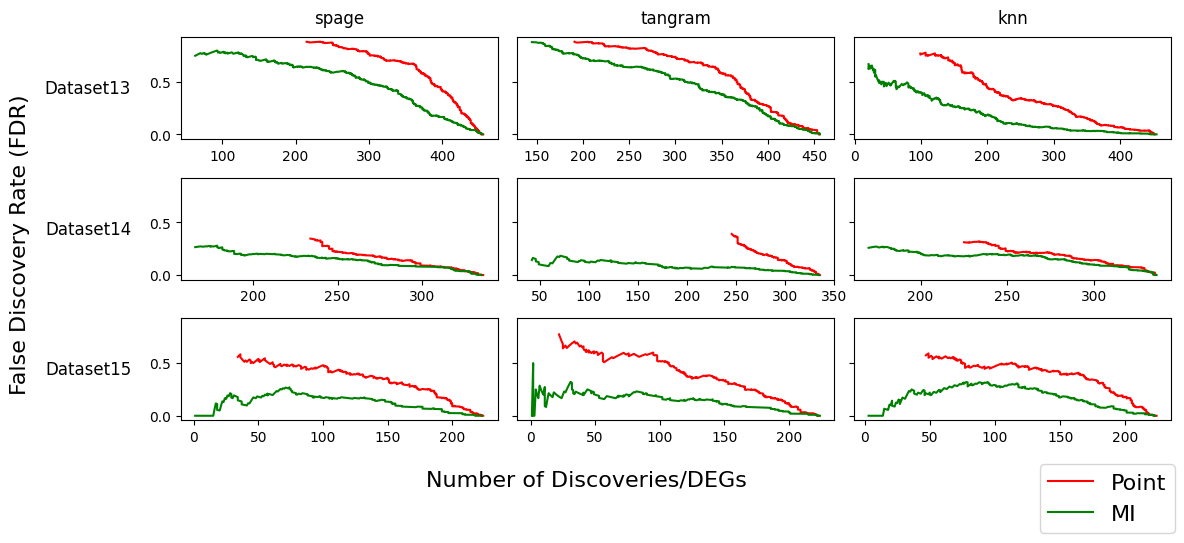

In [10]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
#p_cutoff_uncorrected_arr = np.concatenate(([-1], 10**np.concatenate((np.linspace(-50, -10, 10000),np.linspace(-10, 3, 10000))))) # will do bonferroni cutoff
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_k4k2.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(12,5), sharex=False, sharey=True)
    
    
    
for i, dataset in enumerate(combined_stat_result_dict.keys()):
            
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        num_pos_1 = []
        num_pos_2 = []
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            #true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
            #imp_labels = agg_y1 < p_cutoff_uncorrected/len(agg_y1)
            #mi_labels = agg_y2 < p_cutoff_uncorrected/len(agg_y2)
            #true_labels = multipletests(agg_x, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            #imp_labels = multipletests(agg_y1, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            #mi_labels = multipletests(agg_y2, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])

            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        
        axs[i, j].plot(num_pos_1, fdr_list_1, color='r', label="Point")
        axs[i, j].plot(num_pos_2, fdr_list_2, color='g', label="MI")

# legend
fig.legend(["Point", "MI"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/paneled_pvalue_numpositives_fdr_curves_k4k2.pdf", bbox_inches='tight')
plt.show()

In [13]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
conditions = ["celltype_lowres", "region", "Region"]


##################
combined_stat_result_dict = {}

for i in range(len(dataset_names)):

    condition=conditions[i]
    dataset_name=dataset_names[i]

    adata = sc.read_h5ad(f'scg_results/scpi/2023Mar4_k3k3_SDbasedCCplus1/{dataset_name}_knn_spage_tangram_MI_TTEST.h5ad')

    combined_stat_result_dict[dataset_name] = {}

    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}

        for g1 in np.unique(adata.obs[condition]):

            key = str(g1)+"_all"
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other

            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values

            # add from var 
            var_key = method+"_"+key
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.var[var_key+"_tstat"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.var[var_key+"_varw"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.var[var_key+"_varb"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.var[var_key+"_poolmean"].values

            # true values
            tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["true_tstat"] = tt

            # point estimate (from just imputed values)
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_k3k3.pkl", "wb") as f:
    pickle.dump(combined_stat_result_dict, f)

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:2170: RuntimeWarning: invalid value encountered in true_divide
  tt = mean_diff/pooled_sd


/tmp/ipykernel_90/2272178902.py:69: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_90/2272178902.py:70: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


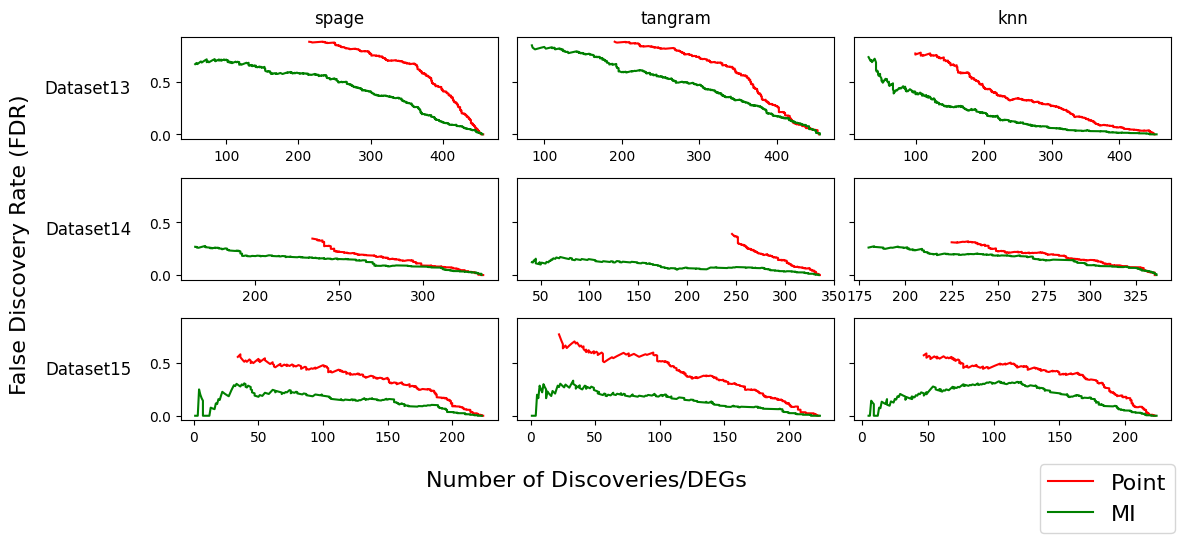

In [14]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
#p_cutoff_uncorrected_arr = np.concatenate(([-1], 10**np.concatenate((np.linspace(-50, -10, 10000),np.linspace(-10, 3, 10000))))) # will do bonferroni cutoff
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_k3k3.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(12,5), sharex=False, sharey=True)
    
    
    
for i, dataset in enumerate(combined_stat_result_dict.keys()):
            
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        num_pos_1 = []
        num_pos_2 = []
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            #true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
            #imp_labels = agg_y1 < p_cutoff_uncorrected/len(agg_y1)
            #mi_labels = agg_y2 < p_cutoff_uncorrected/len(agg_y2)
            #true_labels = multipletests(agg_x, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            #imp_labels = multipletests(agg_y1, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            #mi_labels = multipletests(agg_y2, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])

            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        
        axs[i, j].plot(num_pos_1, fdr_list_1, color='r', label="Point")
        axs[i, j].plot(num_pos_2, fdr_list_2, color='g', label="MI")

# legend
fig.legend(["Point", "MI"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/paneled_pvalue_numpositives_fdr_curves_k3k3.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_43/1787013672.py:63: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_43/1787013672.py:64: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
/tmp/ipykernel_43/1787013672.py:67: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
/tmp/ipykernel_43/1787013672.py:67: RuntimeWarning: invalid value encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
/tmp/ipykernel_43/1787013672.py:68: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='g', label="MI")
/tmp/ipykernel_43/1787013672.py:68: RuntimeWarning: invalid value encountered in log10
  

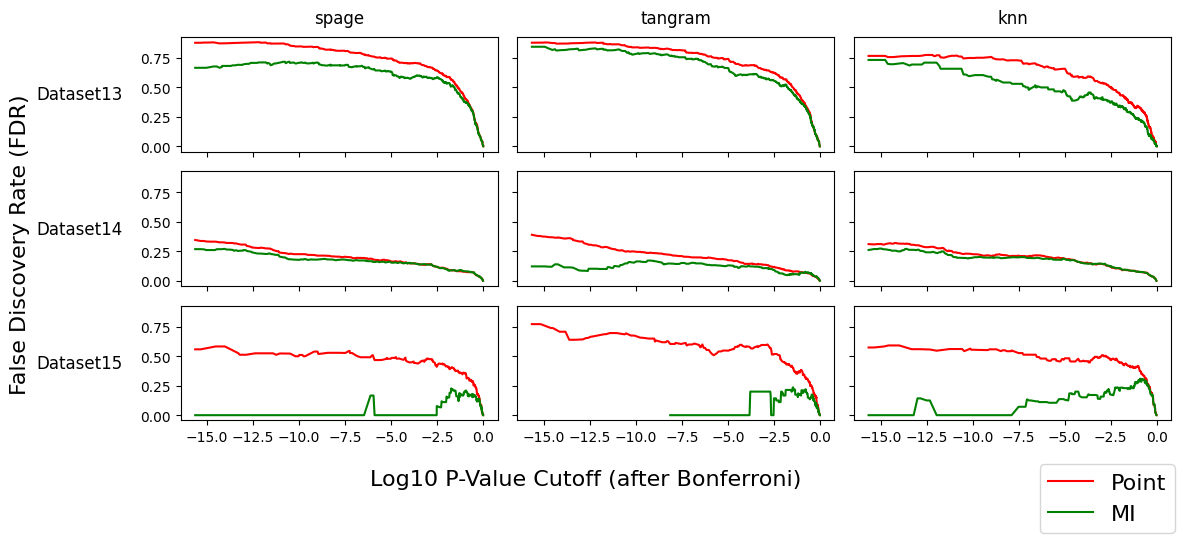

In [5]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset13", "Dataset14", "Dataset15"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_k3k3.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n1 = len(list(combined_stat_result_dict.keys()))
n2 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(12,5), sharex=True, sharey=True)
    
    
    
for i, dataset in enumerate(combined_stat_result_dict.keys()):
            
    for j, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in p_cutoff_uncorrected_arr:
            
            # get positive hits
            #true_labels = agg_x < p_cutoff_uncorrected/len(agg_x)
            #imp_labels = agg_y1 < p_cutoff_uncorrected/len(agg_y1)
            #mi_labels = agg_y2 < p_cutoff_uncorrected/len(agg_y2)
            true_labels = multipletests(agg_x, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            imp_labels = multipletests(agg_y1, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]
            mi_labels = multipletests(agg_y2, alpha=p_cutoff_uncorrected, method='fdr_bh')[0]

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])

            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
        
        
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Point")
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='g', label="MI")

# legend
fig.legend(["Point", "MI"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Log10 P-Value Cutoff (after Bonferroni)", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
rows = list(combined_stat_result_dict.keys())
cols = list(combined_stat_result_dict[dataset].keys())
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/paneled_pvalue_dosage_fdr_curves_k3k3.pdf", bbox_inches='tight')
plt.show()

## Constructing gene lists for unmeasured gene imputation experiments

### Pia markers for somatosensory cortex dataset

In [13]:
# read in scRNAseq data
dataset_name = "Dataset15"
adata, RNAseq_adata = load_paired_datasets("DataUpload/"+dataset_name+"/Spatial_count.txt",
                                            "DataUpload/"+dataset_name+"/Locations.txt",
                                            "DataUpload/"+dataset_name+"/scRNA_count.txt")
gene_names = [g.lower() for g in RNAseq_adata.var_names]
spatial_gene_names = [g.lower() for g in adata.var_names]

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:63: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  spatial_adata = ad.AnnData(X=df)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:99: FutureWarning: X.dtype being converted to np.float32 from int64. In the next v

In [14]:
desisto_2020_genes_pia = ["Lama2", "S100a6"]
desisto_2020_genes_arachnoid = ["Crabp2", "Raldh2"]
desisto_2020_genes_dural = ["Crapb2", "Mgp"]

desisto_2020_genes = desisto_2020_genes_pia + desisto_2020_genes_arachnoid + desisto_2020_genes_dural
desisto_2020_genes = [g.lower() for g in desisto_2020_genes]

# remove ones already in spatial genes
desisto_2020_genes = [g for g in desisto_2020_genes if g not in spatial_gene_names]


# check for overlap with Dataset15 scRNAseq profile
overlap_genes = np.intersect1d(desisto_2020_genes, gene_names)
print(desisto_2020_genes)
print(overlap_genes)

np.savetxt("DataUpload/Dataset15/pia_genes.txt", overlap_genes, fmt="%s")

['lama2', 's100a6', 'crabp2', 'raldh2', 'crapb2', 'mgp']
['crabp2' 'lama2' 'mgp' 's100a6']


In [15]:
print(np.intersect1d(overlap_genes,spatial_gene_names))

[]


In [24]:
np.genfromtxt("DataUpload/Dataset15/pia_genes.txt", dtype=str)

array(['crabp2', 'lama2', 'mgp', 's100a6'], dtype='<U6')

### Neuronal subclass markers (using MERFISH panel) for the mouse brain coronal section

In [2]:
# read in scRNAseq data
dataset_name = "Dataset13"
with open("DataUpload/"+dataset_name+"/scRNA_count.txt","r") as f:
    lines=f.readlines()
    result=[]
    for x in lines:
        result.append(x.split('\t')[0])

gene_names = result[1:] 
gene_names = [g.lower() for g in gene_names]


with open("DataUpload/"+dataset_name+"/spatial_count.txt","r") as f:
    line=f.readline()
    result=line.split('\t')

spatial_gene_names = result[1:] 
spatial_gene_names = [g.lower() for g in spatial_gene_names]

In [3]:
excN = ["Slc17a7", "Slc17a6"]
inhN = ["Slc32a1", "Gad1", "Gad2"]
interN = ["Pvalb", "Sst", "Vip", "Lamp5"]
pepN = ["Trh","Tac1","Tac2","Penk","Hcrt","Agrp","Pomc","Npy"]
msN = ["Drd1","Drd2","Adora2a"]
choN = ["Chat"]
dopN = ["Slc6a3","Th"]
serN = ["Tph2"]

NSC = ['Thbs4', 'Prom1', 'Egfr', 'Mik67', 'Mcm2', 'Slc1a3', 'Sox9', 'Vcam1']
Neuroblast = ['Sox11', 'Dcx', 'Cd24a', 'Tubb3', 'Dlx1']
Granule = ['Prox1', 'Pdzd2', 'Lct', 'Gsg1l', 'Spata13', 'Stra6', 'Trhr', 'Cpne7', 'Grp', 'Nr2f2', 'Tox3']
Mossy = ['Calb2', 'Nmb', 'Thbs2', 'Tm4sf1']



merfish_genes = excN + inhN + interN + pepN + msN + choN + dopN + serN + NSC + Neuroblast + Granule + Mossy
merfish_genes = [g.lower() for g in merfish_genes]

# remove ones already in spatial gene panel
merfish_genes = [g for g in merfish_genes if g not in spatial_gene_names]

# check for overlap with Dataset15 scRNAseq profile
overlap_genes = np.intersect1d(merfish_genes, gene_names)

# additional exclusions from filtering
add_exc_genes = ['adora2a', 'slc6a3']

overlap_genes = np.setdiff1d(overlap_genes,add_exc_genes)
print(overlap_genes)

np.savetxt("DataUpload/Dataset13/subclass_genes.txt", overlap_genes, fmt="%s")

['agrp' 'calb2' 'cd24a' 'chat' 'dcx' 'dlx1' 'drd1' 'drd2' 'egfr' 'gad2'
 'grp' 'gsg1l' 'hcrt' 'lct' 'mcm2' 'nmb' 'npy' 'nr2f2' 'pdzd2' 'pomc'
 'prom1' 'prox1' 'slc17a6' 'slc1a3' 'slc32a1' 'sox11' 'sox9' 'spata13'
 'sst' 'stra6' 'tac1' 'thbs2' 'thbs4' 'tm4sf1' 'tox3' 'tph2' 'trh' 'trhr'
 'tubb3' 'vcam1' 'vip']


In [4]:
for gene in Granule:
    if gene.lower() in gene_names:
        print(gene)

Prox1
Pdzd2
Lct
Gsg1l
Spata13
Stra6
Trhr
Cpne7
Grp
Nr2f2
Tox3


In [5]:
print(np.intersect1d(overlap_genes,spatial_gene_names))

[]


## DGEA results for external (unmeasured) genes

In [18]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset15", "Dataset13"]
conditions = ["Region", "celltype"]

group1 = [["Pia Layer 1"], None]


##################
combined_stat_result_dict = {}

for i in range(len(dataset_names)):

    condition=conditions[i]
    dataset_name=dataset_names[i]

    #adata = sc.read_h5ad(f'scg_results/scpi/{dataset_name}_knn_spage_tangram_MI_EXTERNAL_TTEST.h5ad')
    adata = sc.read_h5ad(f'scg_results/scpi/2023Feb20_k4k1_SDbasedCCplus1/{dataset_name}_knn_spage_tangram_MI_EXTERNAL_TTEST.h5ad')

    combined_stat_result_dict[dataset_name] = {}

    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}
        
        if group1[i] is None:
            group1[i] = np.unique(adata.obs[condition])
        
        for g1 in group1[i]:

            key = str(g1)+"_all"
            var_key = method+"_"+key
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other

            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.uns[var_key+"_pvalue"].columns

            # add from uns
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.uns[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.uns[var_key+"_tstat"].values
            #combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.uns[var_key+"_varw"].values
            #combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.uns[var_key+"_varb"].values
            #combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.uns[var_key+"_poolmean"].values

            # point estimate (from just imputed values)
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][combined_stat_result_dict[dataset_name][method][key]["gene"]].values,
                                      g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_external.pkl", "wb") as f:
    pickle.dump(combined_stat_result_dict, f)

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:2170: RuntimeWarning: invalid value encountered in true_divide
  tt = mean_diff/pooled_sd


In [19]:
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_external.pkl", "wb") as f:
    pickle.dump(combined_stat_result_dict, f)

### Dataset 15: Pia layer marker genes

In [20]:
dataset_names = ["Dataset15", "Dataset13"]

with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_external.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

In [21]:
# find differences in DEGs of markers based on bonferroni cutoff between MI and point estimates
dataset = "Dataset15"
group1 = "Pia Layer 1_all"
target_genes = np.genfromtxt("DataUpload/"+dataset+"/pia_genes.txt", dtype=str)


method_col = []
gene_col = []
tstat_diff_col = []
p_val_imp = []
p_val_mi = []


for method in combined_stat_result_dict[dataset].keys():
    
    # subset genes
    genes = combined_stat_result_dict[dataset][method][group1]["gene"]
    target_bools = np.isin(genes, target_genes)
    
    # compute diffs
    diffs = np.abs(combined_stat_result_dict[dataset][method][group1]["mi_tstat"]-combined_stat_result_dict[dataset][method][group1]["imp_tstat"])
    
    # add results
    method_col.append([method]*np.sum(target_bools))
    gene_col.append(genes[target_bools])
    tstat_diff_col.append(diffs.flatten()[target_bools])
    
    p_val_imp.append(combined_stat_result_dict[dataset][method][group1]["imp_pvalue"].flatten()[target_bools])
    p_val_mi.append(combined_stat_result_dict[dataset][method][group1]["mi_pvalue"].flatten()[target_bools])
    
method_col = np.concatenate(method_col)
gene_col = np.concatenate(gene_col)
tstat_diff_col = np.concatenate(tstat_diff_col)
p_val_imp = np.concatenate(p_val_imp)
p_val_mi = np.concatenate(p_val_mi)

res_df = pd.DataFrame([])
res_df["gene"] = gene_col
res_df["method"] = method_col
res_df["abs_tstat_diff"] = tstat_diff_col
res_df["p_val_imp"] = p_val_imp
res_df["p_val_mi"] = p_val_mi

In [12]:
res_df

gene   method  abs_tstat_diff  p_val_imp  p_val_mi
0   crabp2    spage        3.684780   0.000006  0.398739
1    lama2    spage        1.083089   0.402450  0.805988
2      mgp    spage        0.788975   0.534528  0.158865
3   s100a6    spage        3.413015   0.000009  0.302589
4   crabp2  tangram        2.626625   0.055646  0.476856
5    lama2  tangram        4.086714   0.000001  0.431255
6      mgp  tangram        3.263943   0.000001  0.105326
7   s100a6  tangram        3.245348   0.000037  0.377198
8   crabp2      knn        2.131031   0.000005  0.015042
9    lama2      knn       13.990701   0.000000  0.000157
10     mgp      knn        0.215665   0.377765  0.505227
11  s100a6      knn        3.491365   0.000258  0.867989

/tmp/ipykernel_43/3036908788.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_exp_df["group"] = [group1 if x else "Other" for x in g1_bool]
/tmp/ipykernel_43/3036908788.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_exp_df['id'] = imp_exp_df.index


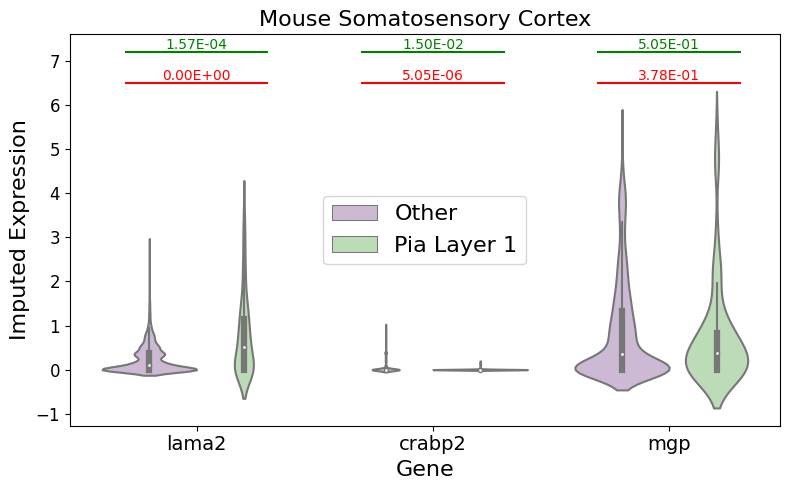

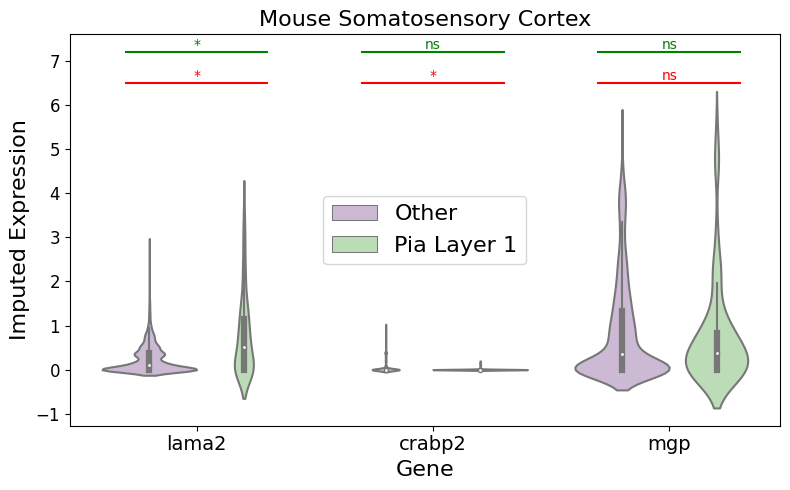

In [13]:
# make violin plots

dataset_name = "Dataset15"
method = "knn"
genes_to_plot = ["lama2", "crabp2", "mgp"]
#condition_colors = ["g", "c"]
condition = "Region"
group1 = "Pia Layer 1"

p_cutoff = 0.05

###########################################

adata = sc.read_h5ad(f'scg_results/scpi/{dataset_name}_knn_spage_tangram_MI_EXTERNAL_TTEST.h5ad')

key = str(group1)+"_all"
var_key = method+"_"+key
g1_bool = (adata.obs[condition] == group1) # g1
g2_bool = (adata.obs[condition] != group1) # all other

# get p-values
mi_pvalues = adata.uns[var_key+"_pvalue"][genes_to_plot]

tt, imp_pvalues = two_sample_ttest(adata.obsm[method+"_predicted_expression"][genes_to_plot].values,
                 g1_bool, g2_bool)

# add group column
imp_exp_df = adata.obsm[method+"_predicted_expression"][genes_to_plot]
imp_exp_df["group"] = [group1 if x else "Other" for x in g1_bool]

# reshape long format
imp_exp_df['id'] = imp_exp_df.index
imp_exp_df = pd.melt(imp_exp_df, id_vars=['id', 'group'], value_vars=genes_to_plot, var_name="gene")
del imp_exp_df['id']
#imp_exp_df.rename({"variable":"gene", "value":"imputed expression"})





# make plot with p-values
plt.figure(figsize=(8,5))
sns.violinplot(x="gene", y="value", hue="group", data=imp_exp_df, palette="PRGn")

# statistical annotation
x_coords = [0, 1, 2, 0, 1, 2]
y_coords = [6.5, 6.5, 6.5, 7.2, 7.2, 7.2]
cols = ['r', 'r', 'r', 'g', 'g', 'g']
h = 0
w = 0.3
pval_labels = np.concatenate((imp_pvalues.flatten(), mi_pvalues.values.flatten()))

for i, label in enumerate(pval_labels):
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    p_label = '%.2E' % Decimal(str(label))
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col)

plt.title("Mouse Somatosensory Cortex", fontsize=16)
plt.xlabel("Gene", fontsize=16)
plt.ylabel("Imputed Expression", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/scpi_dgea/ExternalPValue_{dataset_name}_{method}_{condition}_{group1}.png", dpi=300, bbox_inches="tight")

plt.show()



# make plot with stars
plt.figure(figsize=(8,5))
sns.violinplot(x="gene", y="value", hue="group", data=imp_exp_df, palette="PRGn")

# statistical annotation
x_coords = [0, 1, 2, 0, 1, 2]
y_coords = [6.5, 6.5, 6.5, 7.2, 7.2, 7.2]
cols = ['r', 'r', 'r', 'g', 'g', 'g']
h = 0
w = 0.3
pval_labels = np.concatenate((imp_pvalues.flatten(), mi_pvalues.values.flatten()))
bonf_cutoff = p_cutoff/4 #len(genes_to_plot)
star_labels = ["*" if pv<bonf_cutoff else "ns" for pv in pval_labels]

for i, label in enumerate(star_labels):
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, label, ha='center', va='bottom', color=col)

plt.title("Mouse Somatosensory Cortex", fontsize=16)
plt.xlabel("Gene", fontsize=16)
plt.ylabel("Imputed Expression", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/scpi_dgea/ExternalSymbol_{dataset_name}_{method}_{condition}_{group1}.png", dpi=300, bbox_inches="tight")
plt.show()

### Dataset 13: Neuronal subclass identification

In [22]:
dataset_names = ["Dataset15", "Dataset13"]

with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_external.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

In [23]:
# find differences in DEGs of markers based on bonferroni cutoff between MI and point estimates
dataset = "Dataset13"
target_genes = np.genfromtxt("DataUpload/"+dataset+"/subclass_genes.txt", dtype=str)

group_col = []
method_col = []
gene_col = []
tstat_diff_col = []
tstat_mi_col = []
pval_diff_col = []
p_val_imp = []
p_val_mi = []

for method in combined_stat_result_dict[dataset].keys():
    for group1 in combined_stat_result_dict[dataset][method].keys():

        # subset genes
        genes = combined_stat_result_dict[dataset][method][group1]["gene"]
        target_bools = np.isin(genes, target_genes)

        # compute diffs
        diffs = np.abs(combined_stat_result_dict[dataset][method][group1]["mi_tstat"]-combined_stat_result_dict[dataset][method][group1]["imp_tstat"])
        pdiffs = np.abs(combined_stat_result_dict[dataset][method][group1]["mi_pvalue"]-combined_stat_result_dict[dataset][method][group1]["imp_pvalue"])
        
        # add results
        method_col.append([method]*np.sum(target_bools))
        group_col.append([group1]*np.sum(target_bools))
        gene_col.append(genes[target_bools])
        tstat_diff_col.append(diffs.flatten()[target_bools])
        tstat_mi_col.append(combined_stat_result_dict[dataset][method][group1]["mi_tstat"].flatten()[target_bools])
        pval_diff_col.append(pdiffs.flatten()[target_bools])

        p_val_imp.append(combined_stat_result_dict[dataset][method][group1]["imp_pvalue"].flatten()[target_bools])
        p_val_mi.append(combined_stat_result_dict[dataset][method][group1]["mi_pvalue"].flatten()[target_bools])

group_col = np.concatenate(group_col)
method_col = np.concatenate(method_col)
gene_col = np.concatenate(gene_col)
tstat_diff_col = np.concatenate(tstat_diff_col)
tstat_mi_col = np.concatenate(tstat_mi_col)
pval_diff_col = np.concatenate(pval_diff_col)
p_val_imp = np.concatenate(p_val_imp)
p_val_mi = np.concatenate(p_val_mi)

res_df = pd.DataFrame([])
res_df["group"] = group_col
res_df["gene"] = gene_col
res_df["method"] = method_col
res_df["abs_tstat_diff"] = tstat_diff_col
res_df["tstat_mi"] = tstat_mi_col
res_df["abs_pval_diff"] = pval_diff_col
res_df["p_val_imp"] = p_val_imp
res_df["p_val_mi"] = p_val_mi

In [24]:
# subset neuron clusters only
res_df = res_df[[True if ("Neuron" in x) else False for x in res_df["group"]]].reset_index()

In [25]:
res_df

index                       group   gene method  abs_tstat_diff  \
0       82            Neuron_Cdh13_all   agrp  spage        3.556725   
1       83            Neuron_Cdh13_all  calb2  spage        0.938029   
2       84            Neuron_Cdh13_all  cd24a  spage        0.758364   
3       85            Neuron_Cdh13_all   chat  spage        0.715494   
4       86            Neuron_Cdh13_all    dcx  spage        1.478613   
..     ...                         ...    ...    ...             ...   
979   1307  Neuron_Th_Dopaminergic_all    trh    knn             NaN   
980   1308  Neuron_Th_Dopaminergic_all   trhr    knn             NaN   
981   1309  Neuron_Th_Dopaminergic_all  tubb3    knn        0.819203   
982   1310  Neuron_Th_Dopaminergic_all  vcam1    knn        1.360132   
983   1311  Neuron_Th_Dopaminergic_all    vip    knn        0.128094   

     tstat_mi  abs_pval_diff     p_val_imp  p_val_mi  
0    0.463776       0.643061  5.878663e-05  0.643120  
1   -1.745287       0.073896  7.309614e-03  0.081206  
2   -1.346432       0.143084  3.535053e-02  0.178434  
3   -0.733376       0.316176  1.474260e-01  0.463602  
4    3.531165       0.000426  5.605358e-07  0.000426  
..        ...            ...           ...       ...  
979 -0.013221            NaN           NaN  0.989458  
980  0.067306            NaN           NaN  0.946376  
981 -0.330748       0.490771  2.502097e-01  0.740981  
982 -1.394097       0.157710  5.900787e-03  0.163610  
983  0.140799       0.101766  9.898640e-01  0.888098  

[984 rows x 9 columns]

In [26]:
# step through and print out independent markers
excN = ["Slc17a7", "Slc17a6"]
inhN = ["Slc32a1", "Gad1", "Gad2"]
interN = ["Pvalb", "Sst", "Vip", "Lamp5"]
pepN = ["Trh","Tac1","Tac2","Penk","Hcrt","Agrp","Pomc","Npy"]
msN = ["Drd1","Drd2","Adora2a"]
choN = ["Chat"]
dopN = ["Slc6a3","Th"]
serN = ["Tph2"]

NSC = ['Thbs4', 'Prom1', 'Egfr', 'Mik67', 'Mcm2', 'Slc1a3', 'Sox9', 'Vcam1']
Neuroblast = ['Sox11', 'Dcx', 'Cd24a', 'Tubb3', 'Dlx1']
Granule = ['Prox1', 'Pdzd2', 'Lct', 'Gsg1l', 'Spata13', 'Stra6', 'Trhr', 'Cpne7', 'Grp', 'Nr2f2', 'Tox3']
Mossy = ['Calb2', 'Nmb', 'Thbs2', 'Tm4sf1']

markers_list = [excN, inhN, interN, pepN, msN, choN, dopN, serN, NSC, Neuroblast, Granule, Mossy]

threshold = 0.05#/len(np.concatenate(markers_list))

for idx, markers in enumerate(markers_list):
    #subdf = res_df[res_df["abs_pval_diff"]>=0.02]
    subdf = res_df[res_df['gene'].isin([x.lower() for x in markers])][["group", "method", "gene",
                                                                     "p_val_imp", "p_val_mi"]]
    # filter for 
    grouped = subdf.groupby(["group", "method"])
    subdf = grouped.filter(lambda x: all(x["p_val_mi"] < threshold))
    print(subdf)
    print("\n\n")

                             group   method     gene     p_val_imp  \
63                 Neuron_Cnr1_all    spage  slc17a6  4.216405e-12   
104     Neuron_Gad1_Inhibitory_all    spage  slc17a6  0.000000e+00   
186  Neuron_R3hdm1_Interneuron_all    spage  slc17a6  0.000000e+00   
227             Neuron_Rasl10a_all    spage  slc17a6  6.259180e-06   
309     Neuron_Th_Dopaminergic_all    spage  slc17a6  5.497434e-07   
350               Neuron_Cdh13_all  tangram  slc17a6  2.986346e-04   
391                Neuron_Cnr1_all  tangram  slc17a6  2.922107e-13   
432     Neuron_Gad1_Inhibitory_all  tangram  slc17a6  0.000000e+00   
514  Neuron_R3hdm1_Interneuron_all  tangram  slc17a6  0.000000e+00   
555             Neuron_Rasl10a_all  tangram  slc17a6  1.684536e-08   
596  Neuron_Slc17a7_Excitatory_all  tangram  slc17a6  7.207723e-07   
637     Neuron_Th_Dopaminergic_all  tangram  slc17a6  6.108103e-06   

         p_val_mi  
63   2.502547e-05  
104  0.000000e+00  
186  0.000000e+00  
227  7.08

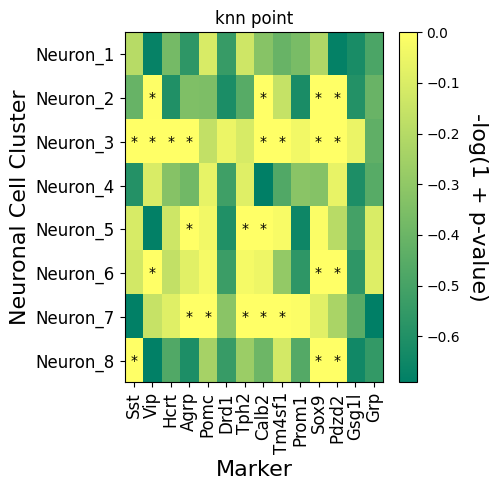

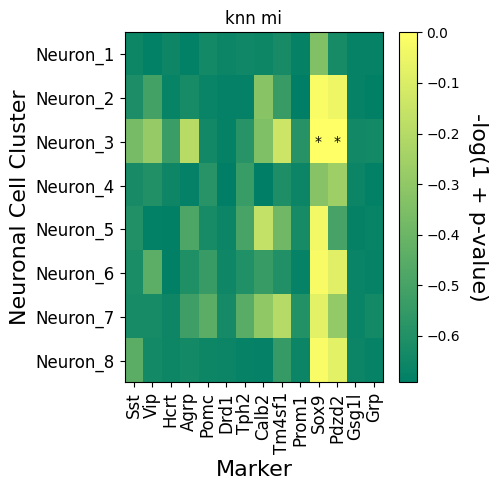

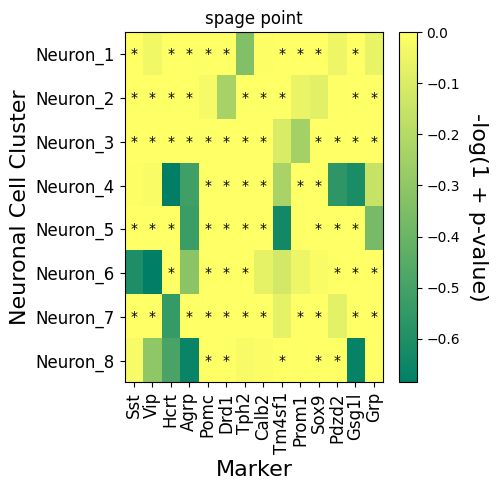

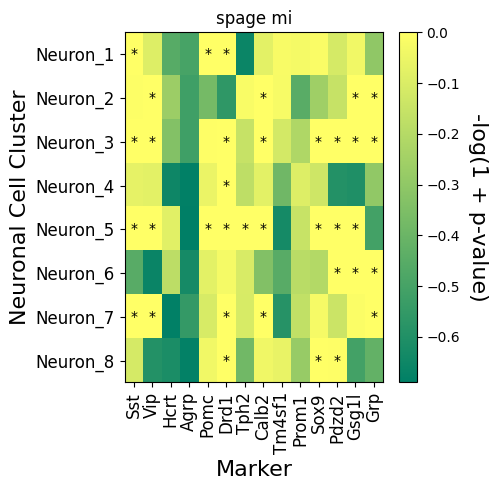

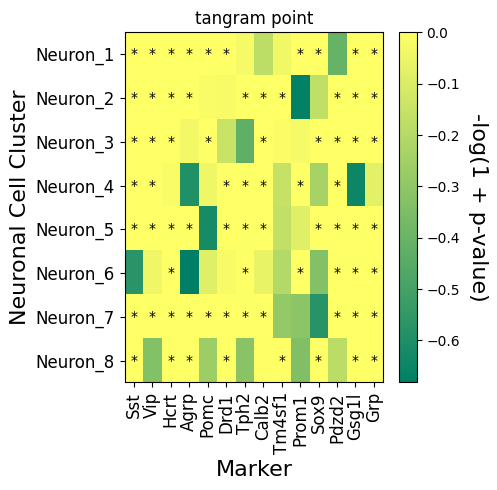

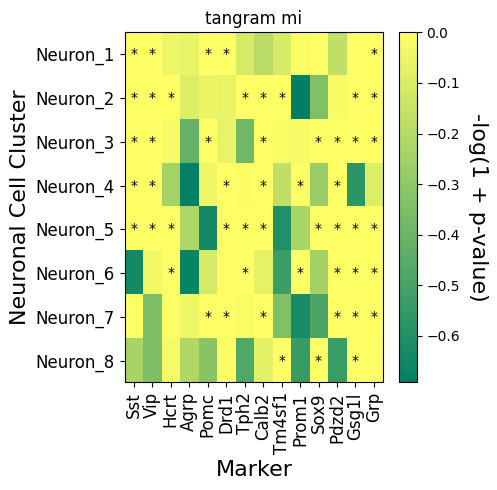

-0.048790164169432014


In [27]:
interN = ["Sst", "Vip"]
pepN = ["Hcrt","Agrp","Pomc"]
msN = ["Drd1"]
serN = ["Tph2"]

NSC = ['Prom1', 'Sox9']
Granule = ['Pdzd2', 'Gsg1l', 'Grp']
Mossy = ['Calb2', 'Tm4sf1']

markers_list = [interN, pepN, msN, serN, Mossy, NSC, Granule]

p_cutoff = 0.05


neuron_dict = {"Neuron_Cdh13":"Neuron_1",
              "Neuron_Cnr1":"Neuron_2",
              "Neuron_Gad1_Inhibitory":"Neuron_3",
              "Neuron_Ndnf":"Neuron_4",
              "Neuron_R3hdm1_Interneuron":"Neuron_5",
              "Neuron_Rasl10a":"Neuron_6",
              "Neuron_Slc17a7_Excitatory":"Neuron_7",
              "Neuron_Th_Dopaminergic":"Neuron_8"}

##################

for method in np.unique(res_df["method"]):
    
    subdf = res_df[res_df["method"]==method]

    result_rows_imp = []
    result_rows_mi = []
    
    # for each group and marker, add the p-value to the corresponding row
    for group in np.unique(res_df['group']):
        
        groupdf = subdf[subdf["group"] == group]
        
        group_imp = []
        group_mi = []
        
        for marker in np.concatenate(markers_list):
            
            if marker.lower() in np.unique(groupdf['gene']):
                
                group_imp.append(groupdf[groupdf["gene"]==marker.lower()]["p_val_imp"].values[0])
                group_mi.append(groupdf[groupdf["gene"]==marker.lower()]["p_val_mi"].values[0])
                
        result_rows_imp.append(group_imp)
        result_rows_mi.append(group_mi)
    
    # make heatmap plots of the -log 10 pvalues
    xticklabels = [x for x in np.concatenate(markers_list) if x.lower() in np.unique(subdf['gene'])]
    yticklabels = np.unique(res_df['group'].str[:-4].replace(neuron_dict))[::-1]
    
    plt.figure(figsize=(5,5))
    plt.title(method+" point")
    plt.imshow(-np.log1p(np.vstack(result_rows_imp)), aspect='auto', cmap="summer")
    plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
    plt.yticks(np.arange(len(yticklabels)), yticklabels[::-1], fontsize=12)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('-log(1 + p-value)', rotation=270, fontsize=16, labelpad=20)
    sig_mask = np.vstack([["*" if x < (p_cutoff/len(xticklabels)) else "" for x in row] for row in result_rows_imp])
    for i in range(len(yticklabels)):
        for j in range(len(xticklabels)):
            text = plt.text(j, i, sig_mask[i, j],
                           ha="center", va="center", color="k")
    plt.xlabel("Marker", fontsize=16)
    plt.ylabel("Neuronal Cell Cluster", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/scpi_dgea/Dataset13_celltype_heatmap_POINT_{method}.pdf", bbox_inches="tight")
    plt.show()
    
    plt.figure(figsize=(5,5))
    plt.title(method+" mi")
    plt.imshow(-np.log1p(np.vstack(result_rows_mi)), aspect='auto', cmap="summer")
    plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
    plt.yticks(np.arange(len(yticklabels)), yticklabels[::-1], fontsize=12)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('-log(1 + p-value)', rotation=270, fontsize=16, labelpad=20)
    sig_mask = np.vstack([["*" if x < (p_cutoff/len(xticklabels)) else "" for x in row] for row in result_rows_mi])
    for i in range(len(yticklabels)):
        for j in range(len(xticklabels)):
            text = plt.text(j, i, sig_mask[i, j],
                           ha="center", va="center", color="k")
    plt.xlabel("Marker", fontsize=16)
    plt.ylabel("Neuronal Cell Cluster", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/scpi_dgea/Dataset13_celltype_heatmap_MI_{method}.pdf", bbox_inches="tight")
    plt.show()
    
print(-np.log1p(0.05))

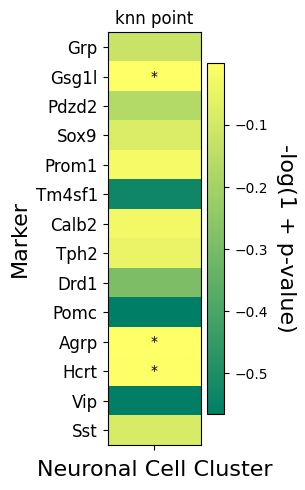

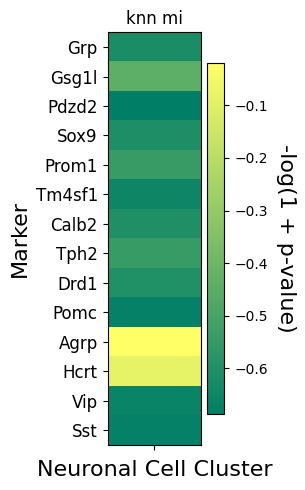

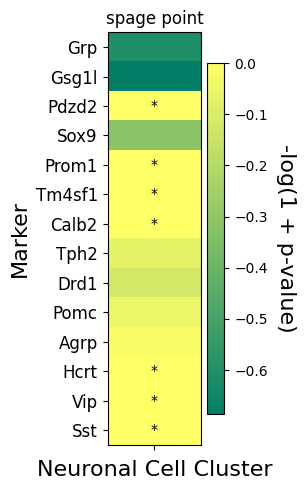

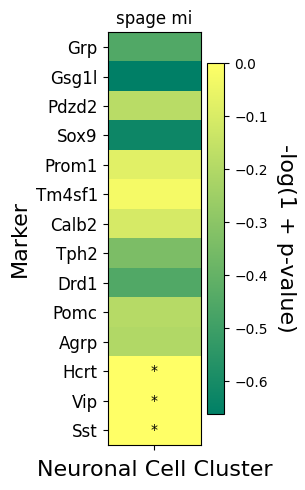

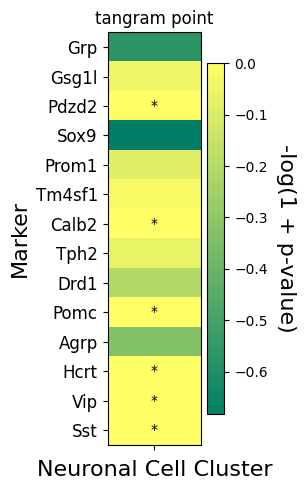

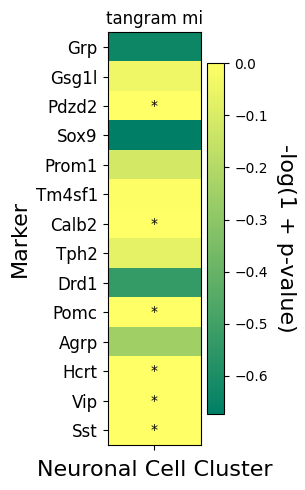

In [28]:
interN = ["Sst", "Vip"]
pepN = ["Hcrt","Agrp","Pomc"]
msN = ["Drd1"]
serN = ["Tph2"]

NSC = ['Prom1', 'Sox9']
Granule = ['Pdzd2', 'Gsg1l', 'Grp']
Mossy = ['Calb2', 'Tm4sf1']

markers_list = [interN, pepN, msN, serN, Mossy, NSC, Granule]

p_cutoff = 0.05


neuron_dict = {"Neuron_Cdh13":"Neuron_1",
              "Neuron_Cnr1":"Neuron_2",
              "Neuron_Gad1_Inhibitory":"Neuron_3",
              "Neuron_Ndnf":"Neuron_4",
              "Neuron_R3hdm1_Interneuron":"Neuron_5",
              "Neuron_Rasl10a":"Neuron_6",
              "Neuron_Slc17a7_Excitatory":"Neuron_7",
              "Neuron_Th_Dopaminergic":"Neuron_8"}


##################

for method in np.unique(res_df["method"]):
    
    subdf = res_df[res_df["method"]==method]
    subdf = subdf[subdf['group']=='Neuron_Rasl10a_all']

    result_rows_imp = []
    result_rows_mi = []
    
    # for each group and marker, add the p-value to the corresponding row
    for group in np.unique(subdf['group']):
        
        groupdf = subdf[subdf["group"] == group]
        
        group_imp = []
        group_mi = []
        
        for marker in np.concatenate(markers_list):
            
            if marker.lower() in np.unique(groupdf['gene']):
                
                group_imp.append(groupdf[groupdf["gene"]==marker.lower()]["p_val_imp"].values[0])
                group_mi.append(groupdf[groupdf["gene"]==marker.lower()]["p_val_mi"].values[0])
                
        result_rows_imp.append(group_imp)
        result_rows_mi.append(group_mi)
    
    # make heatmap plots of the -log 10 pvalues
    yticklabels = [x for x in np.concatenate(markers_list) if x.lower() in np.unique(subdf['gene'])]
    xticklabels = ["Neuron (Unknown)"]
    
    plt.figure(figsize=(3,5))
    plt.title(method+" point")
    plt.imshow(-np.log1p(np.vstack(result_rows_imp)).T, aspect='auto', cmap="summer")
    plt.xticks(np.arange(len(xticklabels)), "", fontsize=12)
    plt.yticks(np.arange(len(yticklabels)), yticklabels[::-1], fontsize=12)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('-log(1 + p-value)', rotation=270, fontsize=16, labelpad=20)
    sig_mask = np.vstack([["*" if x < (p_cutoff/len(yticklabels)) else "" for x in row] for row in result_rows_imp])
    for i in range(len(yticklabels)):
        text = plt.text(0, i, sig_mask[0, i],
                       ha="center", va="center", color="k")
    plt.ylabel("Marker", fontsize=16)
    plt.xlabel("Neuronal Cell Cluster", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/scpi_dgea/Dataset13_celltype_heatmap_POINT_{method}_granule_only.pdf", bbox_inches="tight")
    plt.show()
    
    plt.figure(figsize=(3,5))
    plt.title(method+" mi")
    plt.imshow(-np.log1p(np.vstack(result_rows_mi)).T, aspect='auto', cmap="summer")
    plt.xticks(np.arange(len(xticklabels)), "", fontsize=12)
    plt.yticks(np.arange(len(yticklabels)), yticklabels[::-1], fontsize=12)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('-log(1 + p-value)', rotation=270, fontsize=16, labelpad=20)
    sig_mask = np.vstack([["*" if x < (p_cutoff/len(yticklabels)) else "" for x in row] for row in result_rows_mi])
    for i in range(len(yticklabels)):
        text = plt.text(0, i, sig_mask[0, i],
                       ha="center", va="center", color="k")
    plt.ylabel("Marker", fontsize=16)
    plt.xlabel("Neuronal Cell Cluster", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/scpi_dgea/Dataset13_celltype_heatmap_MI_{method}_granule_only.pdf", bbox_inches="tight")
    plt.show()

In [23]:
# check for higher expression  --> positive means higher in group1
res_df[(res_df['gene'].isin([g.lower() for g in Granule]))&(res_df['group']=="Neuron_Rasl10a_all")]

index               group   gene   method  abs_tstat_diff   tstat_mi  \
215    297  Neuron_Rasl10a_all    grp    spage        8.988057   3.412832   
216    298  Neuron_Rasl10a_all  gsg1l    spage        9.951511   4.998246   
223    305  Neuron_Rasl10a_all  pdzd2    spage        4.250673   5.659365   
543    748  Neuron_Rasl10a_all    grp  tangram        1.173492   7.143273   
544    749  Neuron_Rasl10a_all  gsg1l  tangram        0.886861  12.920700   
551    756  Neuron_Rasl10a_all  pdzd2  tangram        2.398849   6.557957   
871   1199  Neuron_Rasl10a_all    grp      knn        2.074487  -0.399299   
872   1200  Neuron_Rasl10a_all  gsg1l      knn        0.840703   0.535910   
879   1207  Neuron_Rasl10a_all  pdzd2      knn        1.351405  -1.676362   

     abs_pval_diff     p_val_imp      p_val_mi  
215   6.870073e-04  0.000000e+00  6.870073e-04  
216   7.186333e-07  0.000000e+00  7.186333e-07  
223   2.051625e-08  0.000000e+00  2.051625e-08  
543   1.088019e-12  2.220446e-16  1.088241e-12  
544   0.000000e+00  0.000000e+00  0.000000e+00  
551   6.769940e-11  0.000000e+00  6.769940e-11  
871   5.959550e-01  9.394936e-02  6.899044e-01  
872   1.685056e-01  7.605340e-01  5.920285e-01  
879   9.163884e-02  2.474150e-03  9.411299e-02

### Make plot of cluster on spatial coordinates

In [29]:
adata = sc.read_h5ad(f'scg_results/scpi/Dataset13_knn_spage_tangram_MI_EXTERNAL_TTEST.h5ad')
adata

AnnData object with n_obs × n_vars = 6000 × 114
    obs: 'Unnamed: 0', 'leiden', 'celltype', 'celltype_lowres', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity'
    uns: 'conf_genes_used', 'knn_Astrocyte_Slc1a2_all_poolmean', 'knn_Astrocyte_Slc1a2_all_pvalue', 'knn_Astrocyte_Slc1a2_all_tstat', 'knn_Astrocyte_Slc1a2_all_varb', 'knn_Astrocyte_Slc1a2_all_varw', 'knn_Endothelial_Syt6_all_poolmean', 'knn_Endothelial_Syt6_all_pvalue', 'knn_Endothelial_Syt6_all_tstat', 'knn_Endothelial_Syt6_all_varb', 'knn_Endothelial_Syt6_all_varw', 'knn_Neuron_Cdh13_all_poolmean', 'knn_Neuron_Cdh13_all_pvalue', 'knn_Neuron_Cdh13_all_tstat', 'knn_Neuron_Cdh13_all_varb', 'knn_Neuron_Cdh13_all_varw', 'knn_Neuron_Cnr1_all_poolmean', 'knn_Neuron_Cnr1_all_pvalue', 'knn_Neuron_Cnr1_all_tstat', 'knn_Neuron_Cnr1_all_varb', 'knn_Neuron_Cnr1_all_varw', 'knn_Neuron_Gad1_Inhibitory_all_poolmean', 'knn_Neuron_Gad1_Inhibitory_all_pvalue', 'knn_Neuron_Gad1_Inhibitory_all_tstat', 'knn_Neuron_Gad1_

In [30]:
adata = adata[adata.obs["celltype_lowres"]=="Neuron"]
adata.obsm["spatial"][:,1] = -adata.obsm["spatial"][:,1]

/tmp/ipykernel_125/1167846429.py:2: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  adata.obsm["spatial"][:,1] = -adata.obsm["spatial"][:,1]


In [31]:
neuron_dict = {"Neuron_Cdh13":"Neuron_1",
              "Neuron_Cnr1":"Neuron_2",
              "Neuron_Gad1_Inhibitory":"Neuron_3",
              "Neuron_Ndnf":"Neuron_4",
              "Neuron_R3hdm1_Interneuron":"Neuron_5",
              "Neuron_Rasl10a":"Neuron_6",
              "Neuron_Slc17a7_Excitatory":"Neuron_7",
              "Neuron_Th_Dopaminergic":"Neuron_8"}

# swap to new labels
adata.obs['celltype'] = adata.obs['celltype'].replace(neuron_dict)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


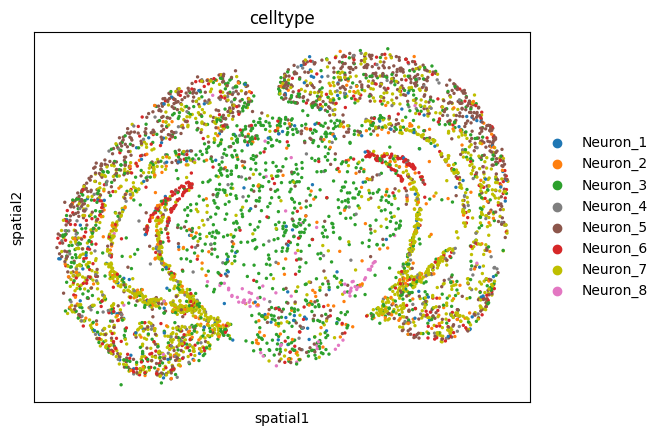

In [32]:
color_dict = {"Neuron_1":"tab:blue",
              "Neuron_2":"tab:orange",
              "Neuron_3":"tab:green",
              "Neuron_4":"tab:gray",
              "Neuron_5":"tab:brown",
              "Neuron_6":"tab:red",
              "Neuron_7":"y",
              "Neuron_8":"tab:pink"}

sc.pl.embedding(adata, "spatial", color="celltype", show=False, palette=color_dict, sort_order=False)
plt.savefig("plots/scpi_dgea/dataset13_clusters_prox1_hippoDG.png", dpi=300, bbox_inches="tight")

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


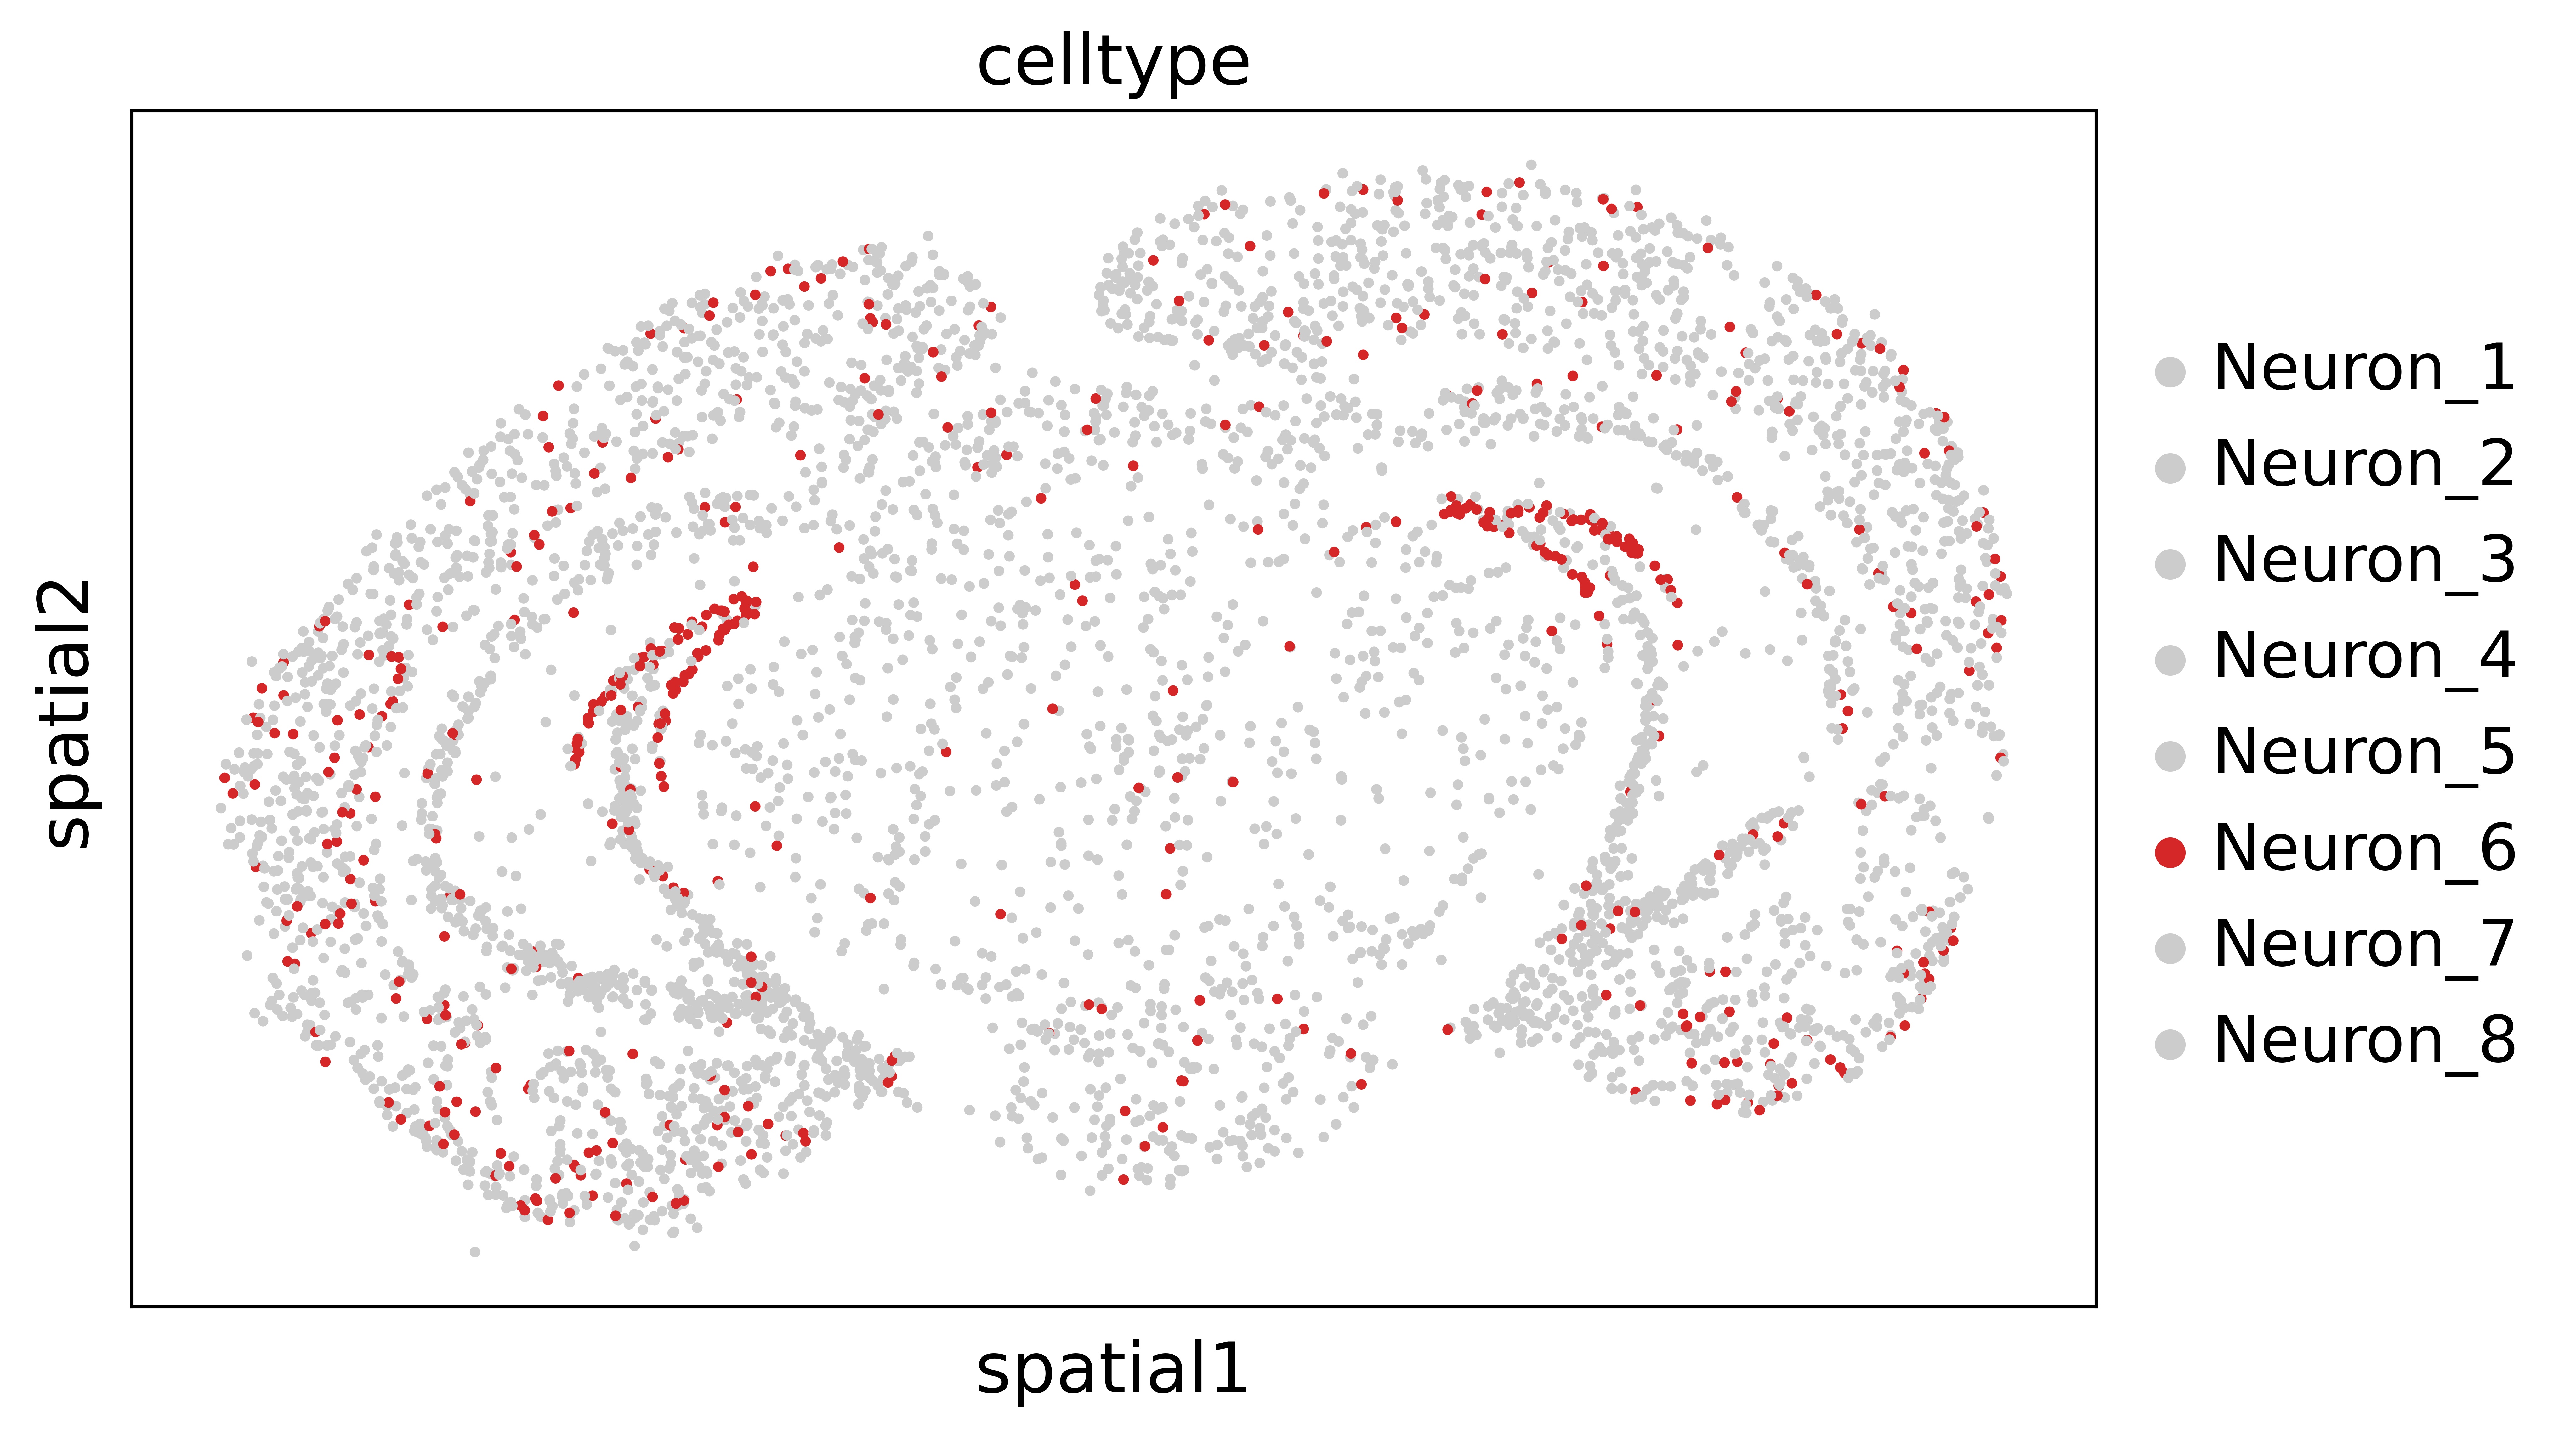

In [38]:
color_dict = {"Neuron_1":"0.8",
              "Neuron_2":"0.8",
              "Neuron_3":"0.8",
              "Neuron_4":"0.8",
              "Neuron_5":"0.8",
              "Neuron_6":"tab:red",
              "Neuron_7":"0.8",
              "Neuron_8":"0.8"}
sc.set_figure_params(vector_friendly=True, dpi=500, figsize=(5,5), fontsize=16)
sc.pl.embedding(adata, "spatial", color="celltype", show=False, palette=color_dict, sort_order=False)
plt.savefig("plots/scpi_dgea/dataset13_clusters_prox1_hippoDG_grayed.pdf", bbox_inches="tight", dpi=500)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


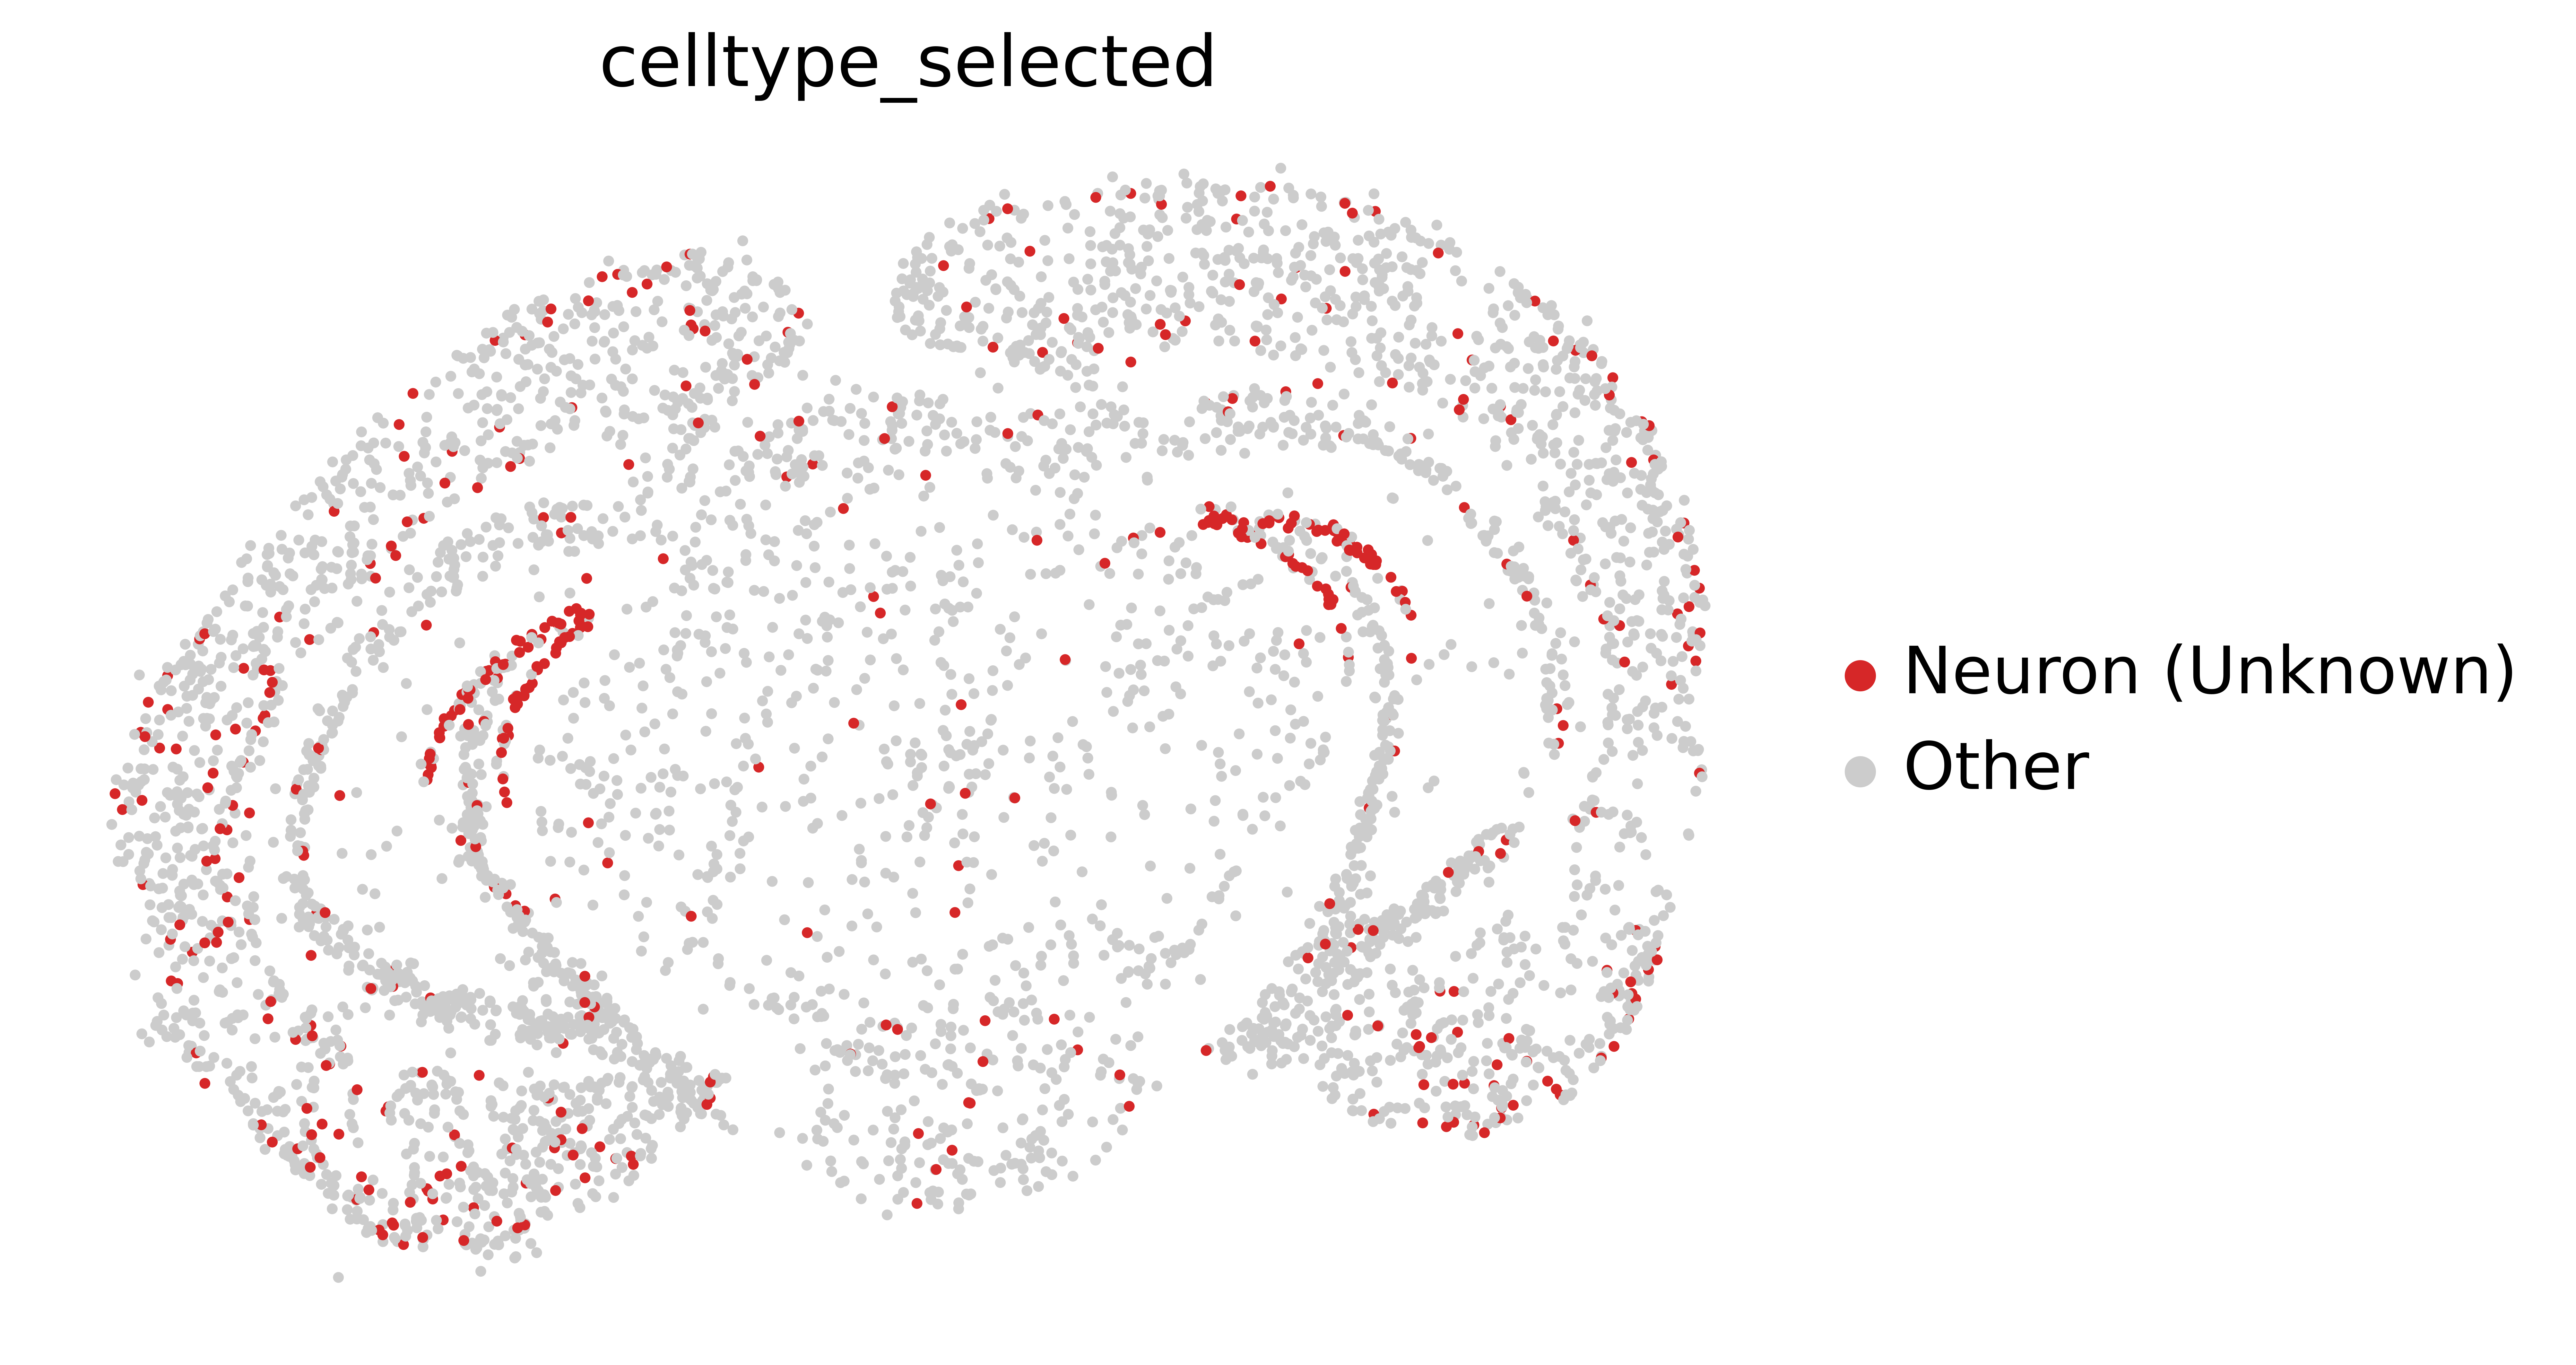

In [41]:
color_dict = {"Neuron (Unknown)":"tab:red",
              "Other":"0.8"}
sc.set_figure_params(vector_friendly=True)
adata.obs["celltype_selected"] = ["Neuron (Unknown)" if x=="Neuron_6" else "Other" for x in adata.obs["celltype"]]
sc.set_figure_params(vector_friendly=True, dpi=500, figsize=(7,5), fontsize=16)
sc.pl.embedding(adata, "spatial", color="celltype_selected", show=False, palette=color_dict, sort_order=False)
plt.axis('off')
plt.savefig("plots/scpi_dgea/dataset13_clusters_prox1_hippoDG_grayed_granule_only.pdf", bbox_inches="tight", dpi=500)